# **Environment Setup**

In [16]:
# --- Imports ---
import os
import sys
import json 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import scipy.signal
import pywt

from collections import defaultdict, Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE

import torch
from torch.utils.data import Dataset, DataLoader, Subset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchinfo import summary
import brevitas.nn as qnn
from brevitas.quant import Int8WeightPerTensorFloat, Int8ActPerTensorFloat, Int8WeightPerChannelFloat, Uint8ActPerTensorFloat

In [17]:
# --- Globals ---

# Valid labels for raw input (before AAMI conversion)
VALID_RAW_LABELS = [
    'N', '·', 'L', 'R', 'e', 'j',
    'A', 'a', 'J', 'S',
    'V', 'E',
    'F',
    '/', 'f', 'Q', '[', ']', '!', 'x', '|'
]

# AAMI Class Mapping
AAMI_CLASSES = {
    'N': ['N', '·', 'L', 'R', 'e', 'j'],
    'S': ['A', 'a', 'J', 'S'],
    'V': ['V', 'E'],
    'F': ['F'],
    'Q': ['/', 'f', 'Q', '[', ']', '!', 'x', '|']
}

# Generate AAMI_MAP from AAMI_CLASSES
AAMI_MAP = {}
for aami_label, raw_list in AAMI_CLASSES.items():
    for raw_label in raw_list:
        AAMI_MAP[raw_label] = aami_label

AAMI_CLASS_NAMES = list(AAMI_CLASSES.keys())  # ['N', 'S', 'V', 'F', 'Q']


## **Load Train, Val, Test made from Colab**

In [18]:
# --- Split train/val/test from .pt-files ---

save_dir = '/home/eveneiha/finn/workspace/ml/data/preprocessed'

train_data = torch.load(os.path.join(save_dir, "train.pt"))
train_inputs = train_data["inputs"]
train_labels = train_data["labels"]
train_ids = train_data["window_ids"]

val_data = torch.load(os.path.join(save_dir, "val.pt"))
val_inputs = val_data["inputs"]
val_labels = val_data["labels"]
val_ids = val_data["window_ids"]

test_data = torch.load(os.path.join(save_dir, "test.pt"))
test_inputs = test_data["inputs"]
test_labels = test_data["labels"]
test_ids = test_data["window_ids"]

class PreprocessedECGDataset(Dataset):
    def __init__(self, inputs, labels, win_ids):
        self.inputs = inputs
        self.labels = labels
        self.win_ids = win_ids

    def __len__(self):
        return self.inputs.size(0)

    def __getitem__(self, idx):
        return self.inputs[idx], self.labels[idx], self.win_ids[idx]

train_dataset = PreprocessedECGDataset(train_inputs, train_labels, train_ids)
val_dataset   = PreprocessedECGDataset(val_inputs, val_labels, val_ids)
test_dataset  = PreprocessedECGDataset(test_inputs, test_labels, test_ids)


batch_size = 16
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


test_inputs_numpy = test_inputs.numpy()
test_labels_numpy = test_labels.numpy()

# Save the data to .npy files
np.save('/home/eveneiha/finn/workspace/ml/data/input.npy', test_inputs_numpy)
np.save('/home/eveneiha/finn/workspace/ml/data/labels.npy', test_labels_numpy)

print("Test data saved to .npy files.")

/tmp/ipykernel_768921/1162946465.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_data = torch.load(os.path.join(save_dir, "train.pt"))
/tmp/ipykernel_768921/116294

Test data saved to .npy files.


/tmp/ipykernel_768921/1162946465.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  test_data = torch.load(os.path.join(save_dir, "test.pt"))


/tmp/ipykernel_768921/4218828469.py:108: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_data = torch.load(os.path.join(save_dir, "train.pt"))



Plotting random window (Raw Label):


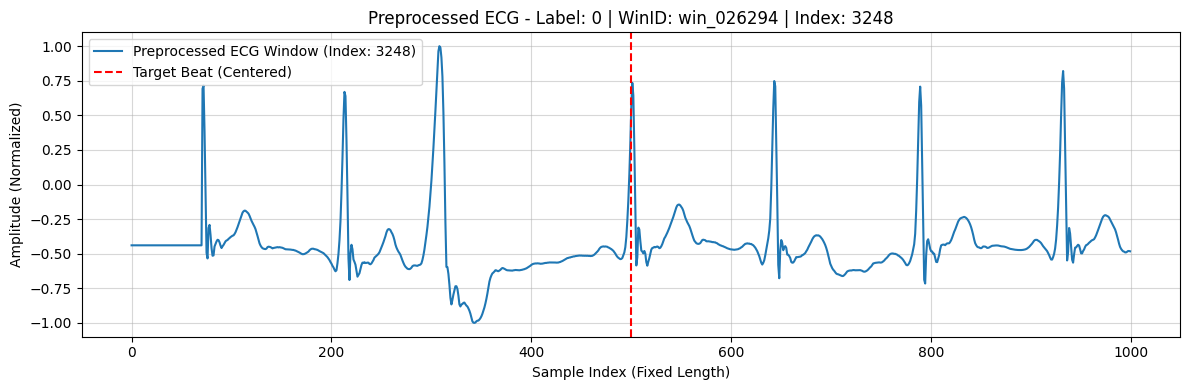


Plotting random window (AAMI Label):


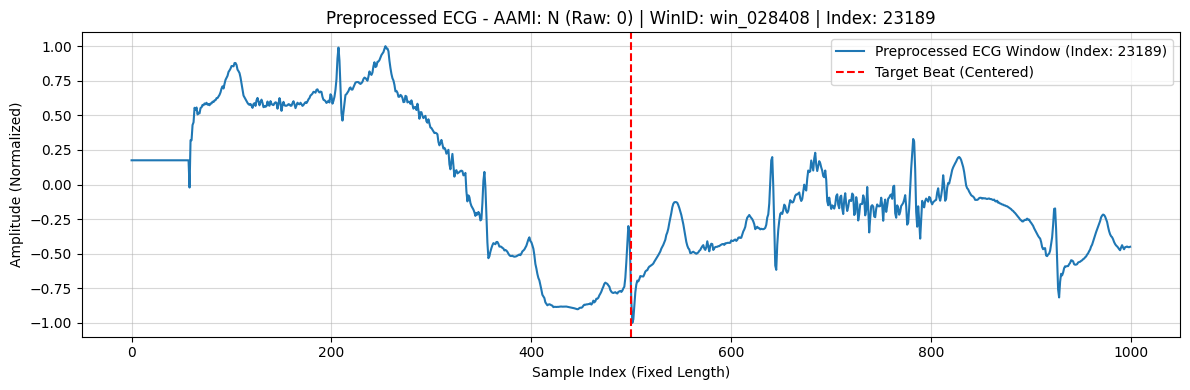


Plotting random window with Label 2 (AAMI Label):
Filtering for labels [2]... (can be slow on large datasets)
Found 4860 samples matching filter.


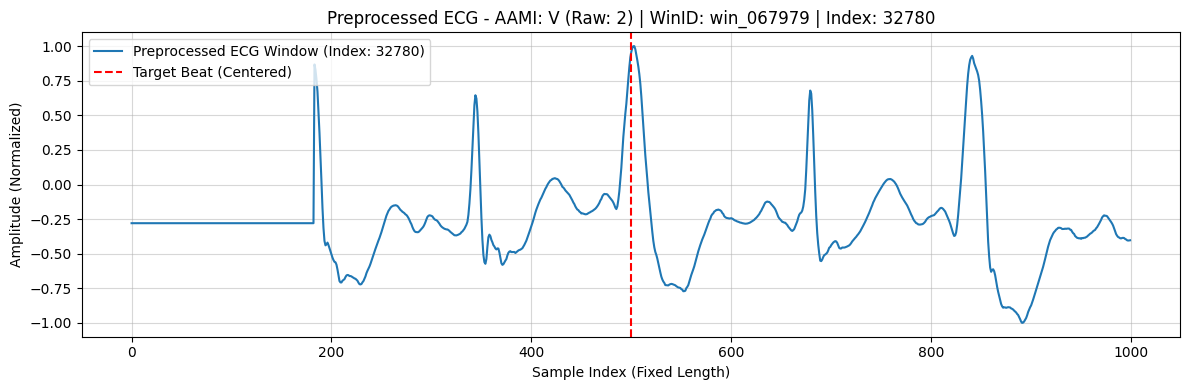


Plotting random window with Label 1 or 2 (Raw Label):
Filtering for labels [1, 2]... (can be slow on large datasets)
Found 6793 samples matching filter.


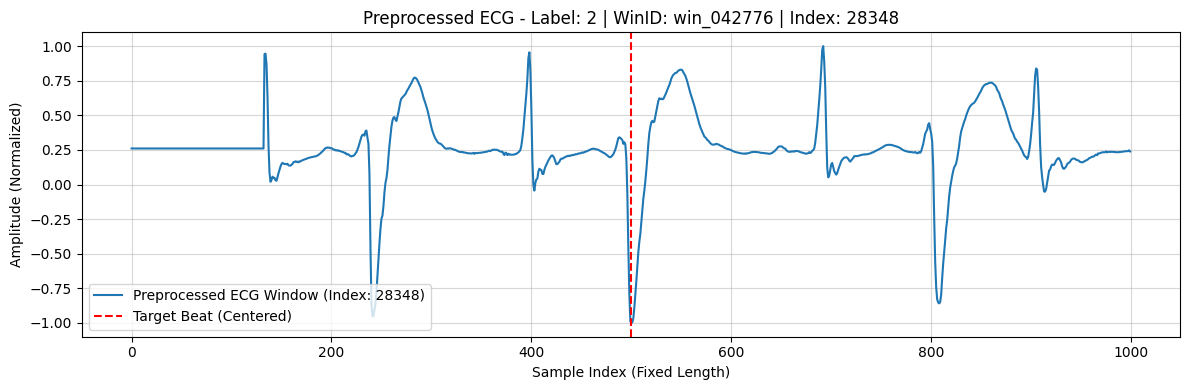

In [19]:
# --- Plotting of inputs for visualization ---

class PreprocessedECGDataset(Dataset):
    def __init__(self, inputs, labels, win_ids):

        self.inputs = inputs.float()
        self.labels = labels.long()
        self.win_ids = win_ids # Assume win_ids are appropriate type already

    def __len__(self):
        return self.inputs.size(0) # Use size(0) for tensor dimension

    def __getitem__(self, idx):
        return self.inputs[idx], self.labels[idx], self.win_ids[idx]

AAMI_MAP = {
    0: 'N',    # Normal beat
    1: 'S',    # Supraventricular ectopic beat (SVEB)
    2: 'V',    # Ventricular ectopic beat (VEB)
    3: 'F',    # Fusion beat
    4: 'Q',    # Unknown beat / Unclassifiable
}


def plot_random_preprocessed_window(data_source, label_filter=None, title_label='raw', figsize=(12, 4)):

    assert title_label in ['raw', 'aami'], "title_label must be 'raw' or 'aami'"
    if title_label == 'aami' and 'AAMI_MAP' not in globals():
        print("⚠️ Warning: title_label='aami' requires AAMI_MAP to be defined globally.")
        print("Falling back to title_label='raw'.")
        title_label = 'raw'

    possible_indices = list(range(len(data_source)))

    # --- Filter indices based on label_filter if provided ---
    if label_filter is not None:
        if isinstance(label_filter, int):
            label_filter = [label_filter] # Ensure it's a list

        filtered_indices = []
        print(f"Filtering for labels {label_filter}... (can be slow on large datasets)")
        # Iterate through indices and check labels efficiently
        all_labels = data_source.labels # Access the full labels tensor directly
        for i in possible_indices:
             # Check if the label at index i is in the filter list
             if all_labels[i].item() in label_filter:
                 filtered_indices.append(i)

        if not filtered_indices:
            print(f"No samples found with label(s): {label_filter}")
            return
        possible_indices = filtered_indices
        print(f"Found {len(possible_indices)} samples matching filter.")

    # --- Select a random sample ---
    if not possible_indices:
        print("No samples available in the dataset.")
        return
    random_idx = random.choice(possible_indices)
    ecg_tensor, label_tensor, window_id_tensor = data_source[random_idx]

    # --- Data Extraction and Preparation ---
    # Ensure tensor is on CPU and convert to numpy
    ecg_np = ecg_tensor.squeeze().cpu().numpy()
    label = label_tensor.item() # Get scalar label value
    # Handle window_id if it's a tensor or scalar
    if torch.is_tensor(window_id_tensor) and window_id_tensor.numel() == 1:
         window_id = window_id_tensor.item()
    else:
         window_id = window_id_tensor # Keep as is if it's already a number or list/etc.


    # Handle potential multi-channel data (plot the first channel)
    if ecg_np.ndim > 1:
        print(f"Input tensor has {ecg_np.shape} shape. Plotting channel 0.")
        ecg_np = ecg_np[0, :] # Select first channel

    fixed_len = ecg_np.shape[0]
    # The preprocessing is assumed to place the target beat at the center
    center_pos = fixed_len // 2

    # --- Plotting ---
    # Choose title based on label mapping
    if title_label == 'aami':
        aami_label_str = AAMI_MAP.get(label, f'Unknown ({label})') # Use get for safety
        title = f"Preprocessed ECG - AAMI: {aami_label_str} (Raw: {label}) | WinID: {window_id} | Index: {random_idx}"
    else: # 'raw'
        title = f"Preprocessed ECG - Label: {label} | WinID: {window_id} | Index: {random_idx}"

    plt.figure(figsize=figsize)
    plt.plot(ecg_np, label=f"Preprocessed ECG Window (Index: {random_idx})")

    # Mark the assumed center (target beat position)
    # Note: We cannot mark other beats as their processed positions are unknown
    plt.axvline(x=center_pos, color='r', linestyle='--', linewidth=1.5, label="Target Beat (Centered)")

    plt.title(title)
    plt.xlabel("Sample Index (Fixed Length)")
    plt.ylabel("Amplitude (Normalized)") # Assuming data is normalized
    plt.legend()
    plt.grid(True, alpha=0.5)
    plt.tight_layout()
    plt.show()


# 1. Load your data (replace with your actual loading)
try:
    train_data = torch.load(os.path.join(save_dir, "train.pt"))
    train_inputs = train_data["inputs"]
    train_labels = train_data["labels"]
    train_ids = train_data["window_ids"]

    # 2. Create Dataset instances
    train_dataset = PreprocessedECGDataset(train_inputs, train_labels, train_ids)

    # 3. Call the plotting function
    print("\nPlotting random window (Raw Label):")
    plot_random_preprocessed_window(train_dataset, title_label='raw')

    print("\nPlotting random window (AAMI Label):")
    plot_random_preprocessed_window(train_dataset, title_label='aami')

    # Example with label filter (e.g., plot only class 2 - 'V' if using AAMI_MAP above)
    print("\nPlotting random window with Label 2 (AAMI Label):")
    plot_random_preprocessed_window(train_dataset, label_filter=2, title_label='aami')

    # Example with multiple label filter
    print("\nPlotting random window with Label 1 or 2 (Raw Label):")
    plot_random_preprocessed_window(train_dataset, label_filter=[1, 2], title_label='raw')

except FileNotFoundError:
    print(f"Error: Data files not found in {save_dir}. Please check the path.")
except KeyError as e:
    print(f"Error: Missing key {e} in loaded .pt file. Ensure files contain 'inputs', 'labels', 'window_ids'.")
    

# **TCN ORIGINAL**

In [20]:
# --- Main TCN Architecture ---


# Load the pruning index map
with open("relevant_indices_per_layer.json") as f:
    pruning_map = json.load(f)



def calculate_receptive_field(layers):
    """
    Compute the receptive field given a sequence of convolution layers.

    Parameters:
      layers (list of dict): Each dictionary should contain:
          - 'kernel_size': The size of the kernel (int)
          - 'dilation': The dilation factor (int; default 1 if not provided)
          - 'stride': The stride used (int; default 1 if not provided)

    Returns:
      int: The overall receptive field (number of input time steps covered by the central output)
    """
    receptive_field = 1  # start with a single input point
    jump = 1             # initial jump (distance between successive receptive field centers)

    for i, layer in enumerate(layers):
        ks = layer['kernel_size']
        dilation = layer.get('dilation', 1)
        stride = layer.get('stride', 1)
        # Calculate effective kernel size for this layer:
        effective_kernel_size = (ks - 1) * dilation + 1

        # Update receptive field
        receptive_field += (effective_kernel_size - 1) * jump

        # Update jump (effective stride from the input perspective)
        jump *= stride

        # Optional: print intermediate values for debugging/understanding
        print(f"Layer {i+1}: kernel_size={ks}, dilation={dilation}, stride={stride}, "
              f"effective_kernel_size={effective_kernel_size}, jump={jump}, "
              f"receptive_field={receptive_field}")

    return receptive_field

# class SliceSelector(nn.Module):
#     def __init__(self, name = None):
#         super().__init__()
        
#         if name != None:
#             self.indices = pruning_map[name]  # Default is no slicing
#         else:
#             self.indices = None
            
#     def forward(self, x):
#         if self.indices is None:
#             return x
#         self.indices = torch.tensor(self.indices, dtype=torch.long)

#         #return x[:, :, self.indices[0]: self.indices[-1], :]
#         return torch.index_select(x, dim=2, index=self.indices) 

class TemporalBlock2d(nn.Module):
    def __init__(self, n_inputs, n_outputs, kernel_size, dilation, stride, dropout=0.2, slice_name= None):
        super(TemporalBlock2d, self).__init__()
        self.kernel_size = kernel_size
        self.dilation = dilation
        self.stride = stride
            
        self.conv1 = qnn.QuantConv2d(
            n_inputs, n_outputs,
            kernel_size=(kernel_size, 1),
            stride=(stride, 1),
            padding=(0, 0),  # no padding – only compute valid outputs
            dilation=(dilation, 1),
            weight_quant=Int8WeightPerChannelFloat,
            input_quant=Int8ActPerTensorFloat,
            weight_bit_width=8,
            act_bit_width=8,
            bias=False
        )
        self.bn1 = nn.BatchNorm2d(n_outputs)
        self.dropout1 = nn.Dropout(dropout)

        # if slice_name is not None:
        #     dilation = 1
            
        self.conv2 = qnn.QuantConv2d(
            n_outputs, n_outputs,
            kernel_size=(kernel_size, 1),
            stride=(1, 1),
            padding=(0, 0),
            dilation=(dilation, 1),
            weight_quant=Int8WeightPerChannelFloat,
            input_quant=Int8ActPerTensorFloat,
            weight_bit_width=8,
            act_bit_width=8,
            bias=False
        )       
        
        self.bn2 = nn.BatchNorm2d(n_outputs)
        self.dropout2 = nn.Dropout(dropout)

        self.relu = qnn.QuantReLU(return_quant_tensor=False, act_quant=Uint8ActPerTensorFloat, output_quant=Int8ActPerTensorFloat)
        #self.slice_selector = SliceSelector(slice_name) 
    

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.dropout1(x)
        #x = self.slice_selector(x) # only on for the final block 
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.dropout2(x)
        return x


class TCN2d(nn.Module):
    def __init__(self, custom_blocks: list, num_outputs: int):
        super(TCN2d, self).__init__()
        self.temporal_blocks = nn.ModuleList(custom_blocks)
        last_out_channels = custom_blocks[-1].conv2.out_channels
                 
        # We also need a 1x1 conv to get to num_outputs
        self.fc = qnn.QuantConv2d(
            in_channels=last_out_channels,
            out_channels=num_outputs,
            kernel_size=(1, 1),
            weight_quant=Int8WeightPerChannelFloat,
            input_quant=Int8ActPerTensorFloat,
            weight_bit_width=8,
            act_bit_width=8,
            bias=False
        )

        self.reduce = qnn.QuantConv2d(
            in_channels=last_out_channels,
            out_channels=last_out_channels,
            kernel_size=(168, 1),  # or use known dims if static
            weight_quant=Int8WeightPerChannelFloat,
            input_quant=Int8ActPerTensorFloat,
            weight_bit_width=8,
            act_bit_width=8,
            bias=False
        )

        
        # Input quant layer
        self.inp_quant = qnn.QuantIdentity(
            bit_width=8,
            act_quant=Int8ActPerTensorFloat,
            return_quant_tensor=True
        )
        self.out_quant = qnn.QuantIdentity(
            bit_width=8,
            act_quant=Int8ActPerTensorFloat,
            return_quant_tensor=True
        )


    def forward(self, x): # Input is float
        #x = self.inp_quant(x) # Output is INT8 tensor value
        for block in self.temporal_blocks:
            x = block(x) 
        x = self.reduce(x)# Pass INT8 tensor value
        x = self.fc(x) # Output likely INT32 internal or QuantTensor
        x_val = x.value if hasattr(x, 'value') else x
        x_val = self.out_quant(x_val)  # Final quantization to INT8
        x_val = x.value if hasattr(x, 'value') else x
        x_reshaped = x_val.reshape(x_val.size(0), -1)
        return x_reshaped
    
block1 = TemporalBlock2d(1, 4, kernel_size=9, dilation=1,  stride=2,  dropout=0.05)
block2 = TemporalBlock2d(4, 8, kernel_size=9, dilation=4,  stride=1,  dropout=0.05)
block3 = TemporalBlock2d(8, 16, kernel_size=9, dilation=16,  stride=1,  dropout=0.05)

custom_blocks = [block1, block2, block3]

layers = [
    {'kernel_size': 9, 'dilation': 1,  'stride': 2},  # Block 1 - Conv1
    {'kernel_size': 9, 'dilation': 1,  'stride': 1},  # Block 1 - Conv2
    {'kernel_size': 9, 'dilation': 4,  'stride': 1},  # Block 2 - Conv1
    {'kernel_size': 9, 'dilation': 4,  'stride': 1},  # Block 2 - Conv2
    {'kernel_size': 9, 'dilation': 16, 'stride': 1},  # Block 3 - Conv1
    {'kernel_size': 9, 'dilation': 16, 'stride': 1},  # Block 3 - Conv2
]

rf = calculate_receptive_field(layers)
print(f"\nFinal receptive field: {rf} input time steps")


Layer 1: kernel_size=9, dilation=1, stride=2, effective_kernel_size=9, jump=2, receptive_field=9
Layer 2: kernel_size=9, dilation=1, stride=1, effective_kernel_size=9, jump=2, receptive_field=25
Layer 3: kernel_size=9, dilation=4, stride=1, effective_kernel_size=33, jump=2, receptive_field=89
Layer 4: kernel_size=9, dilation=4, stride=1, effective_kernel_size=33, jump=2, receptive_field=153
Layer 5: kernel_size=9, dilation=16, stride=1, effective_kernel_size=129, jump=2, receptive_field=409
Layer 6: kernel_size=9, dilation=16, stride=1, effective_kernel_size=129, jump=2, receptive_field=665

Final receptive field: 665 input time steps


## **SETUP TRAINING** 

In [21]:

# Instantiate model and move to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TCN2d(custom_blocks=custom_blocks, num_outputs=5).to(device)

# Store one input sample for testing,
# this is fetched by deploy.py and included in the zip-file for pynq
inputs = test_data["inputs"]
sample = inputs[1].unsqueeze(0)
finn_sample = sample.permute(0,2,3,1)
np.save("/home/eveneiha/finn/workspace/ml/data/finn_sample.npy", finn_sample.numpy())

# Optimizer
lr = 0.007
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)


summary(model, input_size=(1, 1, 1000, 1))#833  # (batch_size, channels, sequence_length)

/home/eveneiha/.pyenv/versions/3.8.16/lib/python3.8/site-packages/torch/nn/modules/conv.py:454: UserWarning: Defining your `__torch_function__` as a plain method is deprecated and will be an error in future, please define it as a classmethod. (Triggered internally at ../torch/csrc/utils/python_arg_parser.cpp:294.)
  return F.conv2d(input, weight, bias, self.stride,


Layer (type:depth-idx)                                                      Output Shape              Param #
TCN2d                                                                       [1, 5]                    --
├─ModuleList: 1-19                                                          --                        (recursive)
│    └─TemporalBlock2d: 2-1                                                 [1, 4, 488, 1]            162
│    │    └─QuantConv2d: 3-1                                                [1, 4, 496, 1]            37
├─QuantIdentity: 1-24                                                       --                        (recursive)
│    └─ActQuantProxyFromInjector: 2-28                                      --                        (recursive)
│    │    └─FusedActivationQuantProxy: 3-45                                 --                        (recursive)
├─ModuleList: 1-19                                                          --                        (recursive)
│   

## **Training**

In [9]:
# --- Load Previous Weights ---

# CPU:
checkpoint = torch.load('./tcn_model_v41_avg_pool.pth', map_location=torch.device('cpu'))

model.load_state_dict(checkpoint['model_state_dict'], strict=False)
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])  # If needed
model.eval()


/tmp/ipykernel_768921/1741715731.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('./tcn_model_v41_avg_pool.pth', map_location=torch.device('cpu')

TCN2d(
  (temporal_blocks): ModuleList(
    (0): TemporalBlock2d(
      (conv1): QuantConv2d(
        1, 4, kernel_size=(9, 1), stride=(2, 1), bias=False
        (input_quant): ActQuantProxyFromInjector(
          (_zero_hw_sentinel): StatelessBuffer()
          (fused_activation_quant_proxy): FusedActivationQuantProxy(
            (activation_impl): Identity()
            (tensor_quant): RescalingIntQuant(
              (int_quant): IntQuant(
                (float_to_int_impl): RoundSte()
                (tensor_clamp_impl): TensorClamp()
                (delay_wrapper): DelayWrapper(
                  (delay_impl): _NoDelay()
                )
                (input_view_impl): Identity()
              )
              (scaling_impl): ParameterFromRuntimeStatsScaling(
                (stats_input_view_shape_impl): OverTensorView()
                (stats): _Stats(
                  (stats_impl): AbsPercentile()
                )
                (restrict_scaling_impl): FloatRestrictVa

In [45]:
# --- Training ---
num_epochs = 1
training_losses = []
validation_losses = []

model.train()  # Set model to training mode

for epoch in range(num_epochs):
    running_loss = 0.0
    batch_count = 0

    # Training loop over batches
    for inputs, targets, _ in train_dataloader:
        inputs = inputs.to(device)
        targets = targets.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)  # Forward pass
        loss = criterion(outputs, targets)
        loss.backward()         # Backpropagation
        optimizer.step()        # Update weights

        running_loss += loss.item()
        batch_count += 1

    train_loss = running_loss / batch_count
    training_losses.append(train_loss)

    # --- Validation ---
    model.eval()  # Switch to evaluation mode
    val_running_loss = 0.0
    val_batch_count = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs_val, targets_val, _ in val_dataloader:
            inputs_val = inputs_val.to(device)
            targets_val = targets_val.to(device)
            outputs_val = model(inputs_val)
            loss_val = criterion(outputs_val, targets_val)

            val_running_loss += loss_val.item()
            val_batch_count += 1

            # Compute accuracy for the batch
            _, predicted = torch.max(outputs_val, 1)
            correct += (predicted == targets_val).sum().item()
            total += targets_val.size(0)

    val_loss = val_running_loss / val_batch_count
    validation_losses.append(val_loss)
    val_acc = correct / total

    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
    model.train() 


Epoch 1/1 - Train Loss: 0.4506, Val Loss: 0.4419, Val Acc: 0.9785



📈 Test Loss: 0.4417
✅ Test Accuracy: 0.9790


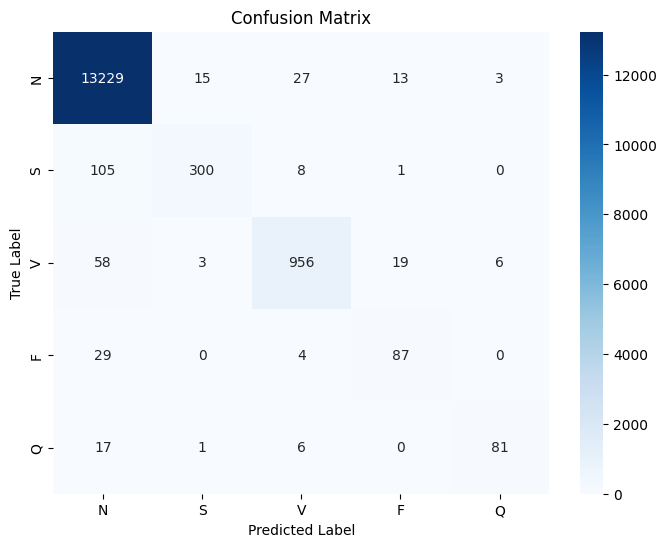

📋 Classification Report:
              precision    recall  f1-score   support

           N       0.98      1.00      0.99     13287
           S       0.94      0.72      0.82       414
           V       0.96      0.92      0.94      1042
           F       0.72      0.72      0.73       120
           Q       0.90      0.77      0.83       105

    accuracy                           0.98     14968
   macro avg       0.90      0.83      0.86     14968
weighted avg       0.98      0.98      0.98     14968



NameError: name 'training_losses' is not defined

<Figure size 1000x500 with 0 Axes>

In [ ]:
# --- Eval Loop --- 
import random
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, f1_score


# Initialize the nested mapping:
# Structure: { predicted_label (str): { true_label (str): [window_id, window_id, ...] } }
misclassified_map = defaultdict(lambda: defaultdict(list))

model.eval()  # Set model to evaluation mode

all_preds = []
all_targets = []
test_loss = 0.0
correct = 0
total = 0

# If needed for other purposes, you can keep lists of misclassified tensors.
misclassified_inputs = []
misclassified_preds = []
misclassified_targets = []

with torch.no_grad():
    # Here, we assume test_dataloader returns (inputs, targets, window_ids)
    for inputs, targets, win_ids in test_dataloader:
        inputs = inputs.to(device)
        targets = targets.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        test_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        correct += (predicted == targets).sum().item()
        total += targets.size(0)

        all_preds.extend(predicted.cpu().numpy())
        all_targets.extend(targets.cpu().numpy())

        # Create a boolean mask for misclassified samples.
        misclassified_mask = predicted != targets
        if misclassified_mask.any():
            # (Optional) Save misclassified tensors if desired:
            misclassified_inputs.extend(inputs[misclassified_mask].cpu())
            misclassified_preds.extend(predicted[misclassified_mask].cpu())
            misclassified_targets.extend(targets[misclassified_mask].cpu())

            # Loop over the current batch and store misclassified window IDs.
            # Note: win_ids is assumed to be a list (or tensor) of window IDs corresponding to the batch.
            # We convert misclassified_mask to CPU and then iterate over indices.
            mis_mask_cpu = misclassified_mask.cpu()
            # For each index in the batch:
            for i in range(len(win_ids)):
                if mis_mask_cpu[i].item():
                    # Convert numeric labels to strings using AAMI_CLASS_NAMES.
                    pred_label = AAMI_CLASS_NAMES[predicted[i].item()]
                    true_label = AAMI_CLASS_NAMES[targets[i].item()]
                    win_id = win_ids[i]
                    misclassified_map[pred_label][true_label].append(win_id)

test_loss /= len(test_dataloader)
test_accuracy = correct / total

print(f"\n📈 Test Loss: {test_loss:.4f}")
print(f"✅ Test Accuracy: {test_accuracy:.4f}")

# Plotting Confusion Matrix
cm = confusion_matrix(all_targets, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=AAMI_CLASS_NAMES,
            yticklabels=AAMI_CLASS_NAMES)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

print("📋 Classification Report:")
print(classification_report(all_targets, all_preds, target_names=AAMI_CLASS_NAMES, zero_division=0))


# Plotting Training and Validation Loss Curve
plt.figure(figsize=(10, 5))
plt.plot(range(len(training_losses)), training_losses, label='Training Loss')
plt.plot(range(len(validation_losses)), validation_losses, label='Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss Curve")
plt.legend()
plt.grid(True)
plt.show()

macro_f1 = f1_score(all_targets, all_preds, average="macro")
weighted_f1 = f1_score(all_targets, all_preds, average="weighted")

print(f"📊 Macro F1-Score: {macro_f1:.4f}")
print(f"📊 Weighted F1-Score: {weighted_f1:.4f}")

In [9]:
def check_all_quant_scalings(model, min_safe=0.005, max_safe=5.0):
    """
    Check all quantized layers and their internal scaling factors.
    """
    for name, module in model.named_modules():
        # Check explicit QuantIdentity layers
        if isinstance(module, qnn.QuantIdentity):
            quantizer = module
            scaling_val = None

            if hasattr(quantizer, "scale"):
                scale_attr = quantizer.scale
                if scale_attr is not None:
                    if callable(scale_attr):
                        scale_val = scale_attr()
                    else:
                        scale_val = scale_attr
                    if scale_val is not None:
                        scaling_val = scale_val.detach().cpu().item()
            if scaling_val is None and hasattr(quantizer, "scaling_impl") and hasattr(quantizer.scaling_impl, "scale"):
                scale_attr = quantizer.scaling_impl.scale
                if scale_attr is not None:
                    scaling_val = scale_attr.detach().cpu().item()

            if scaling_val is not None:
                print(f"🔎 QuantIdentity {name}: scaling = {scaling_val:.6f}")
                if not (min_safe <= scaling_val <= max_safe):
                    print(f"⚠️  WARNING: {name} scaling {scaling_val:.6f} is outside safe range [{min_safe}, {max_safe}]!")
            else:
                print(f"⚠️  QuantIdentity {name}: no scaling available!")

        # Check input/output/weight/bias quantizers inside modules
        for attr_name in ["input_quant", "output_quant", "weight_quant", "bias_quant"]:
            if hasattr(module, attr_name):
                quantizer = getattr(module, attr_name)
                scaling_val = None

                if quantizer is not None:
                    if hasattr(quantizer, "scale"):
                        scale_attr = quantizer.scale
                        if scale_attr is not None:
                            if callable(scale_attr):
                                scale_val = scale_attr()
                            else:
                                scale_val = scale_attr
                            if scale_val is not None:
                                scaling_val = scale_val.detach().cpu().item()
                    if scaling_val is None and hasattr(quantizer, "scaling_impl") and hasattr(quantizer.scaling_impl, "scale"):
                        scale_attr = quantizer.scaling_impl.scale
                        if scale_attr is not None:
                            scaling_val = scale_attr.detach().cpu().item()

                    if scaling_val is not None:
                        print(f"🔎 {name}.{attr_name}: scaling = {scaling_val:.6f}")
                        if not (min_safe <= scaling_val <= max_safe):
                            print(f"⚠️  WARNING: {name}.{attr_name} scaling {scaling_val:.6f} is outside safe range [{min_safe}, {max_safe}]!")
                    else:
                        print(f"⚠️  {name}.{attr_name}: no scaling available!")




                
model.eval()
check_all_quant_scalings(model)

🔎 temporal_blocks.0.conv1.input_quant: scaling = 0.008209
⚠️  temporal_blocks.0.conv1.output_quant: no scaling available!
🔎 temporal_blocks.0.conv1.weight_quant: scaling = 0.008110
⚠️  temporal_blocks.0.conv1.bias_quant: no scaling available!
🔎 temporal_blocks.0.conv2.input_quant: scaling = 0.074152
⚠️  temporal_blocks.0.conv2.output_quant: no scaling available!
🔎 temporal_blocks.0.conv2.weight_quant: scaling = 0.012216
⚠️  temporal_blocks.0.conv2.bias_quant: no scaling available!
⚠️  temporal_blocks.0.relu.input_quant: no scaling available!
⚠️  QuantIdentity temporal_blocks.0.relu_quant: no scaling available!
⚠️  temporal_blocks.0.relu_quant.input_quant: no scaling available!
⚠️  QuantIdentity temporal_blocks.0.act_quant1: no scaling available!
⚠️  temporal_blocks.0.act_quant1.input_quant: no scaling available!
⚠️  QuantIdentity temporal_blocks.0.act_quant2: no scaling available!
⚠️  temporal_blocks.0.act_quant2.input_quant: no scaling available!
🔎 temporal_blocks.1.conv1.input_quant:

## **SAVE WEIGHTS**

In [46]:
# --- Save model ---

torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),  # If you want to save optimizer state
}, './tcn_model_v41_avg_pool.pth')

print("Training Done, model weights are saved")


Training Done, model weights are saved


In [ ]:
# --- Inspect Weights --- 

print("\n🔍 Weight stats for all layers:")
for name, param in model.named_parameters():
    if "weight" in name:
        print(f"Layer {name} weight stats:")
        print(f"  min: {param.data.min().item()}")
        print(f"  max: {param.data.max().item()}")
        print(f"  std: {param.data.std().item()}")




🔍 Weight stats for all layers:
Layer temporal_blocks.0.conv1.weight weight stats:
  min: -0.3067815899848938
  max: 0.3107941746711731
  std: 0.1862936019897461
Layer temporal_blocks.0.bn1.weight weight stats:
  min: 1.0
  max: 1.0
  std: 0.0
Layer temporal_blocks.0.conv2.weight weight stats:
  min: -0.16623477637767792
  max: 0.16487102210521698
  std: 0.09667742997407913
Layer temporal_blocks.0.bn2.weight weight stats:
  min: 1.0
  max: 1.0
  std: 0.0
Layer temporal_blocks.1.conv1.weight weight stats:
  min: -0.1651925891637802
  max: 0.16448301076889038
  std: 0.0975150614976883
Layer temporal_blocks.1.bn1.weight weight stats:
  min: 1.0
  max: 1.0
  std: 0.0
Layer temporal_blocks.1.conv2.weight weight stats:
  min: -0.11780940741300583
  max: 0.11775120347738266
  std: 0.06758382171392441
Layer temporal_blocks.1.bn2.weight weight stats:
  min: 1.0
  max: 1.0
  std: 0.0
Layer temporal_blocks.2.conv1.weight weight stats:
  min: -0.11762907356023788
  max: 0.11764520406723022
  std: 

## **Export onnx** 

In [47]:
# --- Export Model ---
from brevitas.export import export_qonnx



# def normalize_model_for_export(model, target_scale=55, max_weight_absval=25):
#     """
#     Normalize all quantizer scales and clamp all weights in the model.

#     Args:
#         model: PyTorch model (Brevitas QAT model)
#         target_scale: Target fixed scale for all quantizers (e.g., 0.05)
#         max_weight_absval: Max absolute value for weights (e.g., 0.25)
#     """
#     print("\n🔧 Starting model normalization before export...")

#     # --- 1. Fix scales ---
#     for name, module in model.named_modules():
#         for attr_name in ['input_quant', 'output_quant', 'weight_quant', 'bias_quant', 'act_quant']:
#             if hasattr(module, attr_name):
#                 quantizer = getattr(module, attr_name)
#                 if quantizer is not None and hasattr(quantizer, 'scale') and quantizer.scale is not None:
#                     if callable(quantizer.scale):
#                         scale_val = quantizer.scale()
#                     else:
#                         scale_val = quantizer.scale

#                     if scale_val is not None and isinstance(scale_val, torch.Tensor):
#                         new_scale_val = torch.ones_like(scale_val) * target_scale
#                         if callable(quantizer.scale):
#                             quantizer.scale = lambda: new_scale_val
#                         else:
#                             quantizer.scale = nn.Parameter(new_scale_val)
#                         print(f"✅ Forced scale for {name}.{attr_name} to {target_scale:.6f}")

#     # --- 2. Clamp weights ---
#     for name, param in model.named_parameters():
#         if "weight" in name:
#             with torch.no_grad():
#                 old_min, old_max = param.min().item(), param.max().item()
#                 param.clamp_(-max_weight_absval, max_weight_absval)
#                 print(f"✅ Clamped {name} weights from min={old_min:.4f}, max={old_max:.4f} to [{-max_weight_absval}, {max_weight_absval}]")

#     print("\n✅ Model normalization done. Ready for export!")
#     model.eval()
#     return model

# # Usage:
# model = normalize_model_for_export(model)

# 2. 🛠️ Fold BatchNorms
#model = fold_batch_norms_and_remove(model)

model.eval()
model = model.to(device)
dummy_input = torch.randn(1, 1, 1000, 1).to(device)

export_qonnx(model, dummy_input, export_path='/home/eveneiha/finn/workspace/finn/onnx/tcn_v41.onnx', opset_version=11)

ir_version: 6
producer_name: "pytorch"
producer_version: "2.4.1"
graph {
  node {
    input: "x.649"
    input: "/temporal_blocks.0/conv1/input_quant/export_handler/Constant_1_output_0"
    input: "/temporal_blocks.0/conv1/input_quant/export_handler/Constant_2_output_0"
    input: "/temporal_blocks.0/conv1/input_quant/export_handler/Constant_output_0"
    output: "/temporal_blocks.0/conv1/input_quant/export_handler/Quant_output_0"
    name: "/temporal_blocks.0/conv1/input_quant/export_handler/Quant"
    op_type: "Quant"
    attribute {
      name: "narrow"
      i: 0
      type: INT
    }
    attribute {
      name: "rounding_mode"
      s: "ROUND"
      type: STRING
    }
    attribute {
      name: "signed"
      i: 1
      type: INT
    }
    domain: "onnx.brevitas"
  }
  node {
    input: "/temporal_blocks.0/conv1/weight_quant/export_handler/Constant_output_0"
    input: "/temporal_blocks.0/conv1/weight_quant/export_handler/Constant_1_output_0"
    input: "/temporal_blocks.0/conv1/

# **TCN_INFERENCE MODULE**

In [34]:
import torch
import torch.nn as nn
import brevitas.nn as qnn
import json 

from brevitas.quant import Int8ActPerTensorFloat, Int8WeightPerTensorFloat


# Load the pruning index map
with open("relevant_indices_per_layer.json") as f:
    pruning_map = json.load(f)


class UnsignedQuantIdentity(qnn.QuantIdentity):
    def forward(self, x):
        qx = super().forward(x)
        # clamped_val = torch.clamp(qx.value, 0, 127)  # not 255 because Int8 only allows up to 127
        # Return a new QuantTensor with clamped values
        return qx #._replace(value=clamped_val)


class SliceSelector(nn.Module):
    def __init__(self, name = None):
        super().__init__()
        self.indice_list = []
        if name != None:
            self.indices = pruning_map[name]  # Default is no slicing
        else:
            self.indices = None
        
            
    def forward(self, x):
        if self.indices is None:
            return x
        #self.indices = torch.tensor(self.indices, dtype=torch.long, device=x.device)

        #return torch.index_select(x, dim=2, index=self.indices)
        return x[:, :, self.indices, :]  
    
class SliceSelectorStep(nn.Module):
    def __init__(self, step = 1):
        super().__init__()
        self.step = step
            
    def forward(self, x):
        return x[:, :, ::self.step, :]  


class TemporalBlock2d_inf(nn.Module):
    def __init__(self, n_inputs, n_outputs, kernel_size, dilation, stride, dropout=0.2, slice_name= None, slice_selector_step=None, use_stride = False):
        super(TemporalBlock2d_inf, self).__init__()
        self.kernel_size = kernel_size
        self.dilation = dilation
        self.stride = stride
        
        if slice_selector_step is not None:
            self.slice_selector_step = SliceSelectorStep(dilation)
            dilation = 1
        else:
            self.slice_selector_step = None   
        self.conv1 = qnn.QuantConv2d(
            n_inputs, n_outputs,
            kernel_size=(kernel_size, 1),
            stride=(stride, 1),
            padding=(0, 0),  # no padding – only compute valid outputs
            dilation=(dilation, 1),
            weight_quant=Int8WeightPerTensorFloat,
            input_quant=Int8ActPerTensorFloat,
            weight_bit_width=8,
            act_bit_width=8,
            bias=False
        )
        self.bn1 = nn.BatchNorm2d(n_outputs)
        self.dropout1 = nn.Dropout(dropout)
         
            
        if slice_name is not None:
            dilation = 1
        
        if use_stride: 
            stride = 4
        else:
            stride = 1
               
        self.conv2 = qnn.QuantConv2d(
            n_outputs, n_outputs,
            kernel_size=(kernel_size, 1),
            stride=(stride, 1),
            padding=(0, 0),
            dilation=(dilation, 1),
            weight_quant=Int8WeightPerTensorFloat,
            input_quant=Int8ActPerTensorFloat,
            weight_bit_width=8,
            act_bit_width=8,
            bias=False
        )
        
        self.bn2 = nn.BatchNorm2d(n_outputs)
        self.dropout2 = nn.Dropout(dropout)

        self.relu_after_conv = qnn.QuantReLU(return_quant_tensor=True)
        self.slice_selector = SliceSelector(slice_name) 

    def forward(self, x):
        x = self.slice_selector_step(x) if self.slice_selector_step is not None else x

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.dropout1(x)
        x = self.slice_selector(x) 

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu_after_conv(x).value
        x = self.dropout2(x)
        return x


class TCN2d_inf(nn.Module):
    def __init__(self, custom_blocks: list, num_outputs: int):
        super(TCN2d_inf, self).__init__()
        self.temporal_blocks = nn.ModuleList(custom_blocks)
        last_out_channels = custom_blocks[-1].conv2.out_channels
                 
        self.fc = qnn.QuantConv2d(
            in_channels=last_out_channels,
            out_channels=num_outputs,
            kernel_size=(1, 1),
            weight_quant=Int8WeightPerTensorFloat,
            input_quant=Int8ActPerTensorFloat,
            weight_bit_width=8,
            act_bit_width=8,
            bias=False
        )
                
        # Input quant layer
        self.inp_quant = qnn.QuantIdentity(
            bit_width=8,
            act_quant=Int8ActPerTensorFloat,
            return_quant_tensor=True
        )

        self.output_quant = UnsignedQuantIdentity(
            bit_width=8,
            act_quant=Int8ActPerTensorFloat,  # still using Int8 under the hood
            return_quant_tensor=True
        )

    def forward(self, x):
        # x = self.inp_quant(x).value
        x = x[:, :, 168:833, :]  # 0-based index
    
        qx = self.inp_quant(x)

        x = qx.value

        for block in self.temporal_blocks:
            x = block(x)

        x = self.fc(x)
        x = self.output_quant(x).value
        x = x.reshape(x.size(0), -1)


        return x
    
    

block1 = TemporalBlock2d_inf(1, 4, kernel_size=9, dilation=1,    stride=2,  dropout=0.05, slice_selector_step=True, use_stride = True) 
block2 = TemporalBlock2d_inf(4, 8, kernel_size=9, dilation=1,    stride=1,  dropout=0.05, slice_selector_step=True) # if this is true then next dilation must be D3= D3_old/D2
block3 = TemporalBlock2d_inf(8, 16, kernel_size=9, dilation=4,  stride=1,  dropout=0.05, slice_selector_step=True)

print(pruning_map["block3_conv2"])
print(pruning_map["block2_conv2"])

custom_blocks_inf = [block1, block2, block3]

layers = [
    {'kernel_size': 9, 'dilation': 1,  'stride': 2},  # Block 1 - Conv1
    {'kernel_size': 9, 'dilation': 1,  'stride': 1},  # Block 1 - Conv2
    {'kernel_size': 9, 'dilation': 4,  'stride': 1},  # Block 2 - Conv1
    {'kernel_size': 9, 'dilation': 4,  'stride': 1},  # Block 2 - Conv2
    {'kernel_size': 9, 'dilation': 16, 'stride': 1},  # Block 3 - Conv1
    {'kernel_size': 9, 'dilation': 16, 'stride': 1},  # Block 3 - Conv2
]

rf = calculate_receptive_field(layers)
print(f"\nFinal receptive field: {rf} input time steps")


[84, 100, 116, 132, 148, 164, 180, 196, 212]
[84, 88, 92, 96, 100, 104, 108, 112, 116, 120, 124, 128, 132, 136, 140, 144, 148, 152, 156, 160, 164, 168, 172, 176, 180, 184, 188, 192, 196, 200, 204, 208, 212, 216, 220, 224, 228, 232, 236, 240, 244, 248, 252, 256, 260, 264, 268, 272, 276, 280, 284, 288, 292, 296, 300, 304, 308, 312, 316, 320, 324, 328, 332, 336, 340, 344, 348, 352, 356, 360, 364, 368, 372]
Layer 1: kernel_size=9, dilation=1, stride=2, effective_kernel_size=9, jump=2, receptive_field=9
Layer 2: kernel_size=9, dilation=1, stride=1, effective_kernel_size=9, jump=2, receptive_field=25
Layer 3: kernel_size=9, dilation=4, stride=1, effective_kernel_size=33, jump=2, receptive_field=89
Layer 4: kernel_size=9, dilation=4, stride=1, effective_kernel_size=33, jump=2, receptive_field=153
Layer 5: kernel_size=9, dilation=16, stride=1, effective_kernel_size=129, jump=2, receptive_field=409
Layer 6: kernel_size=9, dilation=16, stride=1, effective_kernel_size=129, jump=2, receptive_field

In [33]:

# Instantiate model and move to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print([type(block) for block in custom_blocks_inf])
model_inf = TCN2d_inf(custom_blocks=custom_blocks_inf, num_outputs=5).to(device)

summary(model_inf, input_size=(1, 1, 1000, 1))#833  # (batch_size, channels, sequence_length)
#summary(model, input_data=sample.to(device))




[<class '__main__.TemporalBlock2d_inf'>, <class '__main__.TemporalBlock2d_inf'>, <class '__main__.TemporalBlock2d_inf'>]


/home/eveneiha/.pyenv/versions/3.8.16/lib/python3.8/site-packages/torch/nn/modules/conv.py:454: UserWarning: Defining your `__torch_function__` as a plain method is deprecated and will be an error in future, please define it as a classmethod. (Triggered internally at ../torch/csrc/utils/python_arg_parser.cpp:294.)
  return F.conv2d(input, weight, bias, self.stride,


Layer (type:depth-idx)                                                      Output Shape              Param #
TCN2d_inf                                                                   [1, 5]                    --
├─QuantIdentity: 1-1                                                        [1, 1, 665, 1]            --
│    └─ActQuantProxyFromInjector: 2-1                                       [1, 1, 665, 1]            --
│    └─ActQuantProxyFromInjector: 2-2                                       [1, 1, 665, 1]            --
│    │    └─FusedActivationQuantProxy: 3-1                                  [1, 1, 665, 1]            1
├─UnsignedQuantIdentity: 1-24                                               --                        (recursive)
│    └─ActQuantProxyFromInjector: 2-27                                      --                        (recursive)
│    │    └─FusedActivationQuantProxy: 3-50                                 --                        (recursive)
├─QuantIdentity: 1-3    

## **LOAD WEIGHTS FROM UNPRUNED MODEL**

In [15]:
# --- Load Model ---

# CPU:
checkpoint = torch.load('./tcn_model_v41_inf.pth', map_location=torch.device('cpu'))

model_inf.load_state_dict(checkpoint['model_state_dict'], strict=False)
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])  # If needed
model_inf.eval()


/tmp/ipykernel_2887700/2764631613.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('./tcn_model_v41_inf.pth', map_location=torch.device('cpu'))


TCN2d_inf(
  (temporal_blocks): ModuleList(
    (0): TemporalBlock2d_inf(
      (slice_selector_step): SliceSelectorStep()
      (conv1): QuantConv2d(
        1, 4, kernel_size=(9, 1), stride=(2, 1), bias=False
        (input_quant): ActQuantProxyFromInjector(
          (_zero_hw_sentinel): StatelessBuffer()
          (fused_activation_quant_proxy): FusedActivationQuantProxy(
            (activation_impl): Identity()
            (tensor_quant): RescalingIntQuant(
              (int_quant): IntQuant(
                (float_to_int_impl): RoundSte()
                (tensor_clamp_impl): TensorClamp()
                (delay_wrapper): DelayWrapper(
                  (delay_impl): _NoDelay()
                )
                (input_view_impl): Identity()
              )
              (scaling_impl): ParameterFromRuntimeStatsScaling(
                (stats_input_view_shape_impl): OverTensorView()
                (stats): _Stats(
                  (stats_impl): AbsPercentile()
                )


📈 Test Loss: 0.6174
✅ Test Accuracy: 0.9826


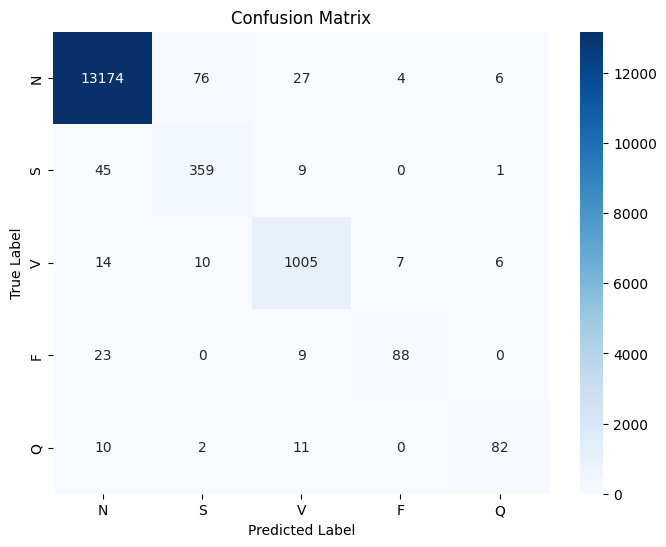

📋 Classification Report:
              precision    recall  f1-score   support

           N       0.99      0.99      0.99     13287
           S       0.80      0.87      0.83       414
           V       0.95      0.96      0.96      1042
           F       0.89      0.73      0.80       120
           Q       0.86      0.78      0.82       105

    accuracy                           0.98     14968
   macro avg       0.90      0.87      0.88     14968
weighted avg       0.98      0.98      0.98     14968



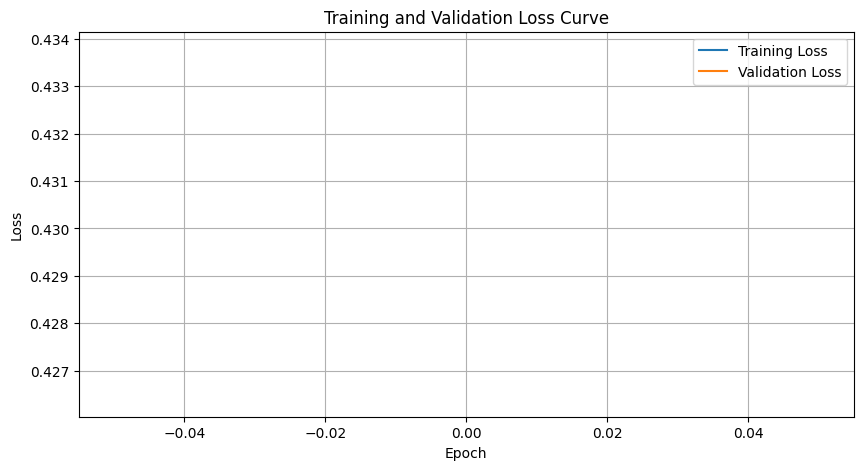

📊 Macro F1-Score: 0.8811
📊 Weighted F1-Score: 0.9826


In [16]:
import random
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, f1_score


# Initialize the nested mapping:
# Structure: { predicted_label (str): { true_label (str): [window_id, window_id, ...] } }
misclassified_map = defaultdict(lambda: defaultdict(list))

model_inf.eval()  # Set model to evaluation mode

all_preds = []
all_targets = []
test_loss = 0.0
correct = 0
total = 0

# If needed for other purposes, you can keep lists of misclassified tensors.
misclassified_inputs = []
misclassified_preds = []
misclassified_targets = []

with torch.no_grad():
    # Here, we assume test_dataloader returns (inputs, targets, window_ids)
    for inputs, targets, win_ids in test_dataloader:
        inputs = inputs.to(device)
        targets = targets.to(device)
        outputs = model_inf(inputs)
        loss = criterion(outputs, targets)
        test_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        correct += (predicted == targets).sum().item()
        total += targets.size(0)

        all_preds.extend(predicted.cpu().numpy())
        all_targets.extend(targets.cpu().numpy())

        # Create a boolean mask for misclassified samples.
        misclassified_mask = predicted != targets
        if misclassified_mask.any():
            # (Optional) Save misclassified tensors if desired:
            misclassified_inputs.extend(inputs[misclassified_mask].cpu())
            misclassified_preds.extend(predicted[misclassified_mask].cpu())
            misclassified_targets.extend(targets[misclassified_mask].cpu())

            # Loop over the current batch and store misclassified window IDs.
            # Note: win_ids is assumed to be a list (or tensor) of window IDs corresponding to the batch.
            # We convert misclassified_mask to CPU and then iterate over indices.
            mis_mask_cpu = misclassified_mask.cpu()
            # For each index in the batch:
            for i in range(len(win_ids)):
                if mis_mask_cpu[i].item():
                    # Convert numeric labels to strings using AAMI_CLASS_NAMES.
                    pred_label = AAMI_CLASS_NAMES[predicted[i].item()]
                    true_label = AAMI_CLASS_NAMES[targets[i].item()]
                    win_id = win_ids[i]
                    misclassified_map[pred_label][true_label].append(win_id)

test_loss /= len(test_dataloader)
test_accuracy = correct / total

print(f"\n📈 Test Loss: {test_loss:.4f}")
print(f"✅ Test Accuracy: {test_accuracy:.4f}")

# Plotting Confusion Matrix
cm = confusion_matrix(all_targets, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=AAMI_CLASS_NAMES,
            yticklabels=AAMI_CLASS_NAMES)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

print("📋 Classification Report:")
print(classification_report(all_targets, all_preds, target_names=AAMI_CLASS_NAMES, zero_division=0))


# Plotting Training and Validation Loss Curve
plt.figure(figsize=(10, 5))
plt.plot(range(len(training_losses)), training_losses, label='Training Loss')
plt.plot(range(len(validation_losses)), validation_losses, label='Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss Curve")
plt.legend()
plt.grid(True)
plt.show()

macro_f1 = f1_score(all_targets, all_preds, average="macro")
weighted_f1 = f1_score(all_targets, all_preds, average="weighted")

print(f"📊 Macro F1-Score: {macro_f1:.4f}")
print(f"📊 Weighted F1-Score: {weighted_f1:.4f}")

In [ ]:
from brevitas.export import export_qonnx

model_inf.eval()
model_inf = model_inf.to(device)
dummy_input = torch.randn(1, 1, 1000, 1).to(device)

export_qonnx(model_inf, dummy_input, export_path='/home/eveneiha/finn/workspace/finn/onnx/tcn_v41_inf.onnx', opset_version=11)

ir_version: 6
producer_name: "pytorch"
producer_version: "2.4.1"
graph {
  node {
    input: "x.619"
    input: "/inp_quant/act_quant/export_handler/Constant_1_output_0"
    input: "/inp_quant/act_quant/export_handler/Constant_2_output_0"
    input: "/inp_quant/act_quant/export_handler/Constant_output_0"
    output: "/inp_quant/act_quant/export_handler/Quant_output_0"
    name: "/inp_quant/act_quant/export_handler/Quant"
    op_type: "Quant"
    attribute {
      name: "narrow"
      i: 0
      type: INT
    }
    attribute {
      name: "rounding_mode"
      s: "ROUND"
      type: STRING
    }
    attribute {
      name: "signed"
      i: 1
      type: INT
    }
    domain: "onnx.brevitas"
  }
  node {
    input: "/inp_quant/act_quant/export_handler/Quant_output_0"
    input: "/temporal_blocks.0/conv1/input_quant/export_handler/Constant_output_0"
    input: "/inp_quant/act_quant/export_handler/Constant_2_output_0"
    input: "/inp_quant/act_quant/export_handler/Constant_output_0"
    

## **ONNXRUNTIME INFERENCE**

In [ ]:
# Export


import torch
import torch.nn as nn
import brevitas.nn as qnn
import json
import onnx

# --- Paste your model definition code here ---
# (Includes potentially simplified UnsignedQuantIdentity, SliceSelector, etc.)
# ... (rest of your model definition, instantiation, weight loading) ...

# --- Set model to evaluation mode ---
model_inf.eval()
print("Model set to evaluation mode.")

# --- Prepare Dummy Input ---
# ... (your dummy input definition) ...
print(f"Using dummy input shape: {dummy_input.shape}")

# --- Define ONNX export parameters ---
onnx_file_path = "tcn_quantized_model_torch_export.onnx" # New name maybe
input_names = ["input"]
output_names = ["output"]
opset_version = 11 # Keep opset 13

# --- Export the model using torch.onnx.export ---
try:
    print(f"Exporting model using torch.onnx.export to: {onnx_file_path}")
    torch.onnx.export(model_inf,
                      dummy_input,
                      onnx_file_path,
                      export_params=True,
                      opset_version=opset_version,
                      do_constant_folding=True, # Keep True
                      input_names=input_names,
                      output_names=output_names,
                      dynamic_axes={'input': {0: 'batch_size', 2: 'time'},
                                    'output': {0: 'batch_size'}}
                     )
    print("ONNX export completed successfully.")

    # Optional: Verify the exported model using ONNX
    onnx_model = onnx.load(onnx_file_path)
    onnx.checker.check_model(onnx_model)
    print("ONNX model check passed.")

except Exception as e:
    print(f"ONNX export failed: {e}")
    import traceback
    traceback.print_exc()

Model set to evaluation mode.
Using dummy input shape: torch.Size([1, 1, 1000, 1])
Exporting model using torch.onnx.export to: tcn_quantized_model_torch_export.onnx


/home/eveneiha/.pyenv/versions/3.8.16/lib/python3.8/site-packages/brevitas/quant_tensor/int_quant_tensor.py:32: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  signed = torch.tensor(signed, dtype=torch.bool)
/home/eveneiha/.pyenv/versions/3.8.16/lib/python3.8/site-packages/brevitas/quant_tensor/int_quant_tensor.py:34: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  training = torch.tensor(training, dtype=torch.bool)
/home/eveneiha/.pyenv/versions/3.8.16/lib/python3.8/site-packages/

ONNX export completed successfully.
ONNX model check passed.


## **QUANTIZED INFERENCE MODULE RUNTIME**

/tmp/ipykernel_2887700/4161732320.py:105: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  test_data = torch.load(os.path.join(save_dir, "test.pt"))


Loading test data from: /home/eveneiha/finn/workspace/ml/data/preprocessed/test.pt
Test data loaded successfully.
Creating test dataset...
DEBUG: Total number of samples in test_dataset: 14968
Creating test dataloader with batch_size = 4, num_workers = 0...
Test dataloader created.

Loading ONNX model from: tcn_quantized_model_torch_export.onnx
Creating ONNX Runtime session...
ONNX Runtime session created successfully.
Using Execution Provider(s): ['CPUExecutionProvider']
Model Input : Name='input', Shape=['batch_size', 1, 'time', 1], Type=tensor(float)
Model Output(s): Names=['output']
  - Primary Output for ArgMax: Name='output', Shape=['batch_size', 'Reshapeoutput_dim_1'], Type=tensor(float)
Expecting NumPy input type for ONNX Runtime: <class 'numpy.float32'>

Starting evaluation on the test set using ONNX Runtime...
Target Class Names: ['N', 'S', 'V', 'F', 'Q']


Evaluating:   0%|          | 6/3742 [00:00<01:13, 51.03it/s]


DEBUG: Shape of first input batch tensor: torch.Size([4, 1, 1000, 1])
DEBUG: Dtype of first input batch tensor: torch.float32


Evaluating: 100%|██████████| 3742/3742 [00:56<00:00, 66.28it/s]



Evaluation loop finished after processing 3742 batches.

--- Evaluation Summary ---
✅ Test Accuracy : 0.9851 (14745/14968)
⏱️ Avg Inference Time / Batch: 14.483 ms

Calculating F1-Scores and Classification Report...
📊 Macro F1-Score : 0.8929
📊 Weighted F1-Score: 0.9847

📋 Classification Report:
              precision    recall  f1-score   support

           N       0.99      1.00      0.99     13287
           S       0.92      0.83      0.87       414
           V       0.98      0.94      0.96      1042
           F       0.89      0.72      0.79       120
           Q       0.86      0.84      0.85       105

    accuracy                           0.99     14968
   macro avg       0.93      0.86      0.89     14968
weighted avg       0.98      0.99      0.98     14968


Generating Confusion Matrix...


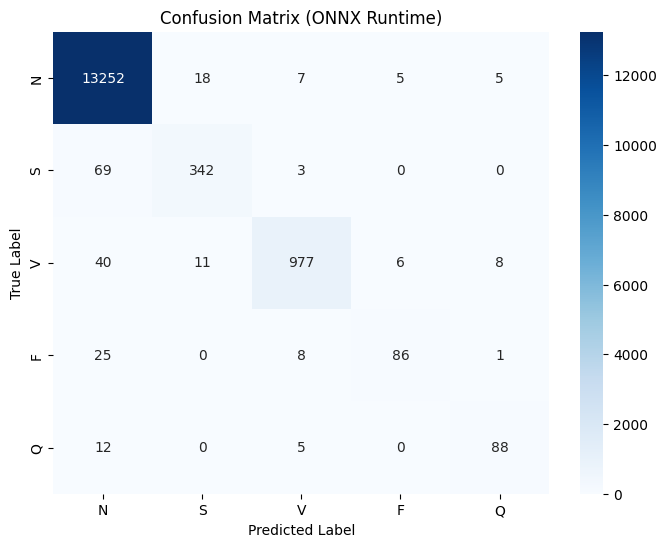


🔍 Misclassified Window IDs Summary:
  - Predicted 'F', True 'N': 5 samples (e.g., ['win_059057', 'win_059112', 'win_059063', 'win_067693', 'win_047780'])
  - Predicted 'F', True 'V': 6 samples (e.g., ['win_067473', 'win_070036', 'win_060159', 'win_068069', 'win_060873']...)
  - Predicted 'N', True 'F': 25 samples (e.g., ['win_067499', 'win_060733', 'win_067465', 'win_070176', 'win_060298']...)
  - Predicted 'N', True 'Q': 12 samples (e.g., ['win_086431', 'win_010856', 'win_086721', 'win_055421', 'win_011080']...)
  - Predicted 'N', True 'S': 69 samples (e.g., ['win_063584', 'win_062121', 'win_041802', 'win_044325', 'win_085205']...)
  - Predicted 'N', True 'V': 40 samples (e.g., ['win_084754', 'win_094693', 'win_041712', 'win_063735', 'win_096302']...)
  - Predicted 'Q', True 'F': 1 samples (e.g., ['win_069645'])
  - Predicted 'Q', True 'N': 5 samples (e.g., ['win_050275', 'win_010852', 'win_008095', 'win_059124', 'win_007952'])
  - Predicted 'Q', True 'V': 8 samples (e.g., ['win_0534

In [21]:
# ==============================================================
#                    IMPORTS
# ==============================================================
import os
import time
from collections import defaultdict

import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm  # For progress bar

import onnxruntime as ort

# --- Metrics & Plotting ---
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, f1_score

# ==============================================================
#                    CONFIGURATION
# ==============================================================

# --- Paths ---
# Directory where preprocessed .pt files are stored
save_dir = '/home/eveneiha/finn/workspace/ml/data/preprocessed'
# Path to your exported & quantized ONNX model
onnx_model_path = "tcn_quantized_model_torch_export.onnx"

# --- DataLoader Settings ---
# !! CRITICAL for memory issues: Start with a VERY SMALL batch size !!
# Try 4, 8, or 16. Increase only if it works without crashing.
batch_size = 4
# Setting num_workers=0 can sometimes help with debugging memory issues
num_workers = 0

# --- Evaluation Settings ---
# Define your AAMI class names (Make sure this matches your training order)
#AAMI_CLASS_NAMES = ['N', 'S', 'V', 'F', 'Q'] # Example - Replace/Confirm

# --- Debugging Settings ---
# Set to a positive integer (e.g., 50) to only process that many batches for testing
# Set to None or 0 to process the entire dataset
MAX_BATCHES_TO_PROCESS = None

# ==============================================================
#          HELPER FUNCTION: ONNX Type to NumPy Dtype
# ==============================================================
def get_numpy_dtype(onnx_type_str):
    """Maps ONNX tensor type strings to NumPy dtypes."""
    type_map = {
        'tensor(float)': np.float32,
        'tensor(double)': np.float64,
        'tensor(int8)': np.int8,
        'tensor(uint8)': np.uint8,
        'tensor(int16)': np.int16,
        'tensor(uint16)': np.uint16,
        'tensor(int32)': np.int32,
        'tensor(uint32)': np.uint32,
        'tensor(int64)': np.int64,
        'tensor(uint64)': np.uint64,
        'tensor(bool)': np.bool_,
        'tensor(float16)': np.float16, # Common alternative name
        'tensor(bfloat16)': np.float16 # Requires appropriate numpy/torch version
    }
    dtype = type_map.get(onnx_type_str)
    if dtype is None:
         # Fallback for slightly different naming conventions if needed
         if 'float16' in onnx_type_str: dtype = np.float16
         elif 'float' in onnx_type_str: dtype = np.float32 # Default float
         # Add more fallbacks if necessary based on error messages
         else:
            raise ValueError(f"Unsupported or unrecognized ONNX type string: {onnx_type_str}")
    return dtype

# ==============================================================
#                    DATA LOADING & PREPARATION
# ==============================================================

# --- Define Dataset Class ---
class PreprocessedECGDataset(Dataset):
    def __init__(self, inputs, labels, win_ids):
        if not (inputs.size(0) == labels.size(0) == len(win_ids)):
             raise ValueError(f"Mismatch in dataset sizes! Inputs: {inputs.size(0)}, Labels: {labels.size(0)}, WinIDs: {len(win_ids)}")
        self.inputs = inputs
        self.labels = labels
        # Ensure win_ids is a list or compatible sequence for indexing
        self.win_ids = list(win_ids) if not isinstance(win_ids, list) else win_ids

    def __len__(self):
        return self.inputs.size(0) # Use tensor size for length

    def __getitem__(self, idx):
        # Return items directly by index
        return self.inputs[idx], self.labels[idx], self.win_ids[idx]

# --- Load Data and Create DataLoaders ---
test_dataloader = None
test_dataset_size = 0
try:
    print(f"Loading test data from: {os.path.join(save_dir, 'test.pt')}")
    if not os.path.exists(os.path.join(save_dir, "test.pt")):
        raise FileNotFoundError(f"Required data file not found: {os.path.join(save_dir, 'test.pt')}")

    test_data = torch.load(os.path.join(save_dir, "test.pt"))
    test_inputs = test_data["inputs"]
    test_labels = test_data["labels"]
    test_ids = test_data["window_ids"]
    print("Test data loaded successfully.")

    print("Creating test dataset...")
    test_dataset = PreprocessedECGDataset(test_inputs, test_labels, test_ids)
    test_dataset_size = len(test_dataset)
    print(f"DEBUG: Total number of samples in test_dataset: {test_dataset_size}")

    if test_dataset_size == 0:
        print("Warning: Test dataset is empty.")

    print(f"Creating test dataloader with batch_size = {batch_size}, num_workers = {num_workers}...")
    test_dataloader = DataLoader(test_dataset,
                                 batch_size=batch_size,
                                 shuffle=False,
                                 num_workers=num_workers)
    print("Test dataloader created.")

except FileNotFoundError as e:
    print(f"FATAL ERROR: {e}")
    exit()
except ValueError as e:
    print(f"FATAL ERROR during dataset creation: {e}")
    exit()
except Exception as e:
    print(f"An unexpected error occurred during data loading: {e}")
    import traceback
    traceback.print_exc()
    exit()

if test_dataloader is None or test_dataset_size == 0:
     print("FATAL ERROR: Test dataloader could not be created or dataset is empty. Exiting.")
     exit()

# ==============================================================
#                ONNX RUNTIME SESSION SETUP
# ==============================================================
session = None
input_name = None
output_names = None
input_type_np = None

print(f"\nLoading ONNX model from: {onnx_model_path}")
if not os.path.exists(onnx_model_path):
    print(f"FATAL ERROR: ONNX model file not found at {onnx_model_path}")
    exit()

try:
    sess_options = ort.SessionOptions()
    # Optional: Fine-tune session options if needed
    # sess_options.intra_op_num_threads = 1 # Example: Limit threads

    print("Creating ONNX Runtime session...")
    session = ort.InferenceSession(onnx_model_path, sess_options, providers=['CPUExecutionProvider'])
    print("ONNX Runtime session created successfully.")
    print(f"Using Execution Provider(s): {session.get_providers()}")

    # --- Get Input/Output Details ---
    input_desc = session.get_inputs()[0]
    output_descs = session.get_outputs() # Get all outputs

    input_name = input_desc.name
    input_shape_model = input_desc.shape
    input_type_model_ort = input_desc.type # String like 'tensor(float)'

    output_names = [o.name for o in output_descs]
    # Assuming the primary output is the first one for classification
    output_name = output_descs[0].name
    output_shape_model = output_descs[0].shape
    output_type_model_ort = output_descs[0].type

    print(f"Model Input : Name='{input_name}', Shape={input_shape_model}, Type={input_type_model_ort}")
    print(f"Model Output(s): Names={output_names}") # Show all output names
    print(f"  - Primary Output for ArgMax: Name='{output_name}', Shape={output_shape_model}, Type={output_type_model_ort}")

    # --- Determine Expected NumPy Input Type ---
    input_type_np = get_numpy_dtype(input_type_model_ort)
    print(f"Expecting NumPy input type for ONNX Runtime: {input_type_np}")

except Exception as e:
    print(f"\nFATAL ERROR: Failed to load ONNX model or create session: {e}")
    import traceback
    traceback.print_exc()
    exit() # Stop if model loading fails









# ==============================================================
#                    EVALUATION
# ==============================================================

# --- Initialization ---
all_preds_np = []
all_targets_np = []
misclassified_map = defaultdict(lambda: defaultdict(list))
correct = 0
total = 0
inference_times = []
processed_batches = 0

print(f"\nStarting evaluation on the test set using ONNX Runtime...")
print(f"Target Class Names: {AAMI_CLASS_NAMES}")
if MAX_BATCHES_TO_PROCESS:
    print(f"DEBUG: Will process a maximum of {MAX_BATCHES_TO_PROCESS} batches.")

# --- Evaluation Loop ---
try:
    # Ensure session is valid
    if session is None:
        raise RuntimeError("ONNX Runtime session is not initialized.")

    # Use torch.no_grad() if any torch operations remain inside loop, otherwise optional
    with torch.no_grad():
        for batch_idx, batch_data in enumerate(tqdm(test_dataloader, desc="Evaluating")):

            # --- Subset Processing Check ---
            if MAX_BATCHES_TO_PROCESS and batch_idx >= MAX_BATCHES_TO_PROCESS:
                print(f"\nDEBUG: Stopping loop early after reaching {MAX_BATCHES_TO_PROCESS} batches.")
                break

            # --- Data Unpacking and Validation ---
            if len(batch_data) != 3:
                 print(f"\nWarning: Dataloader expected to yield 3 items (inputs, targets, win_ids), but got {len(batch_data)} at batch {batch_idx}. Skipping batch.")
                 continue
            inputs_torch, targets_torch, win_ids = batch_data

            # Add input shape debug print for the first batch
            if batch_idx == 0:
                print(f"\nDEBUG: Shape of first input batch tensor: {inputs_torch.shape}")
                print(f"DEBUG: Dtype of first input batch tensor: {inputs_torch.dtype}")
                # Check if batch size matches dataloader setting
                if inputs_torch.shape[0] != batch_size and len(test_dataloader) > 1:
                     print(f"Warning: Input batch size {inputs_torch.shape[0]} doesn't match DataLoader batch_size {batch_size}. This might happen on the last batch.")


            # --- 1. Prepare Inputs for ONNX Runtime ---
            # Convert to NumPy array with the correct dtype expected by the model input
            try:
                 inputs_np = inputs_torch.cpu().numpy().astype(input_type_np)
            except Exception as e:
                 print(f"\nError converting input batch {batch_idx} to NumPy with dtype {input_type_np}: {e}")
                 print(f"Input tensor dtype was: {inputs_torch.dtype}")
                 continue # Skip this batch

            # --- 2. Prepare Targets (keep as NumPy on CPU) ---
            targets_np = targets_torch.cpu().numpy()

            # --- 3. Run ONNX Inference ---
            try:
                start_time = time.perf_counter()
                # Provide input as a dictionary {input_name: input_data}
                outputs_list = session.run(output_names, {input_name: inputs_np})
                end_time = time.perf_counter()
                inference_times.append(end_time - start_time)

                # outputs_list contains results for all model outputs in order of output_names
                # Get the primary output for classification (assuming it's the first one)
                output_np = outputs_list[0]

            except Exception as e:
                print(f"\nError during ONNX Runtime inference at batch {batch_idx}: {e}")
                print(f"Input shape provided: {inputs_np.shape}, dtype: {inputs_np.dtype}")
                # Depending on severity, you might want to 'continue' or 'break' or 'exit()'
                break # Stop evaluation if inference fails

            # --- 4. Process Output to get Predictions ---
            try:
                # Argmax assumes the class dimension is axis 1 (shape: batch, num_classes)
                # Verify this assumption based on printed model output shape
                if len(output_np.shape) < 2 or output_np.shape[1] != len(AAMI_CLASS_NAMES):
                     print(f"\nWarning: Unexpected output shape {output_np.shape} at batch {batch_idx}. Cannot reliably perform argmax for {len(AAMI_CLASS_NAMES)} classes along axis 1. Skipping batch.")
                     continue

                predicted_np = np.argmax(output_np, axis=1)
            except Exception as e:
                 print(f"\nError processing model output (argmax) at batch {batch_idx}: {e}")
                 print(f"Output shape was: {output_np.shape}")
                 continue # Skip batch if output processing fails

            # --- 5. Update Metrics ---
            correct += np.sum(predicted_np == targets_np)
            total += targets_np.shape[0]

            all_preds_np.extend(predicted_np)
            all_targets_np.extend(targets_np)

            # --- 6. Track Misclassifications ---
            misclassified_mask = predicted_np != targets_np
            if np.any(misclassified_mask):
                # Iterate over the samples *in this batch* that were misclassified
                for i in np.where(misclassified_mask)[0]:
                    pred_label_idx = predicted_np[i]
                    true_label_idx = targets_np[i]

                    # Get window ID safely
                    win_id = win_ids[i] if i < len(win_ids) else "Unknown_WinID"

                    # Ensure indices are valid before accessing AAMI_CLASS_NAMES
                    if 0 <= pred_label_idx < len(AAMI_CLASS_NAMES) and 0 <= true_label_idx < len(AAMI_CLASS_NAMES):
                         pred_label = AAMI_CLASS_NAMES[pred_label_idx]
                         true_label = AAMI_CLASS_NAMES[true_label_idx]
                         misclassified_map[pred_label][true_label].append(win_id)
                    else:
                         print(f"Warning: Index out of bounds at batch {batch_idx}, index {i}. Pred: {pred_label_idx}, True: {true_label_idx}. WinID: {win_id}. Skipping misclassification log.")

            processed_batches += 1

except Exception as e:
    print(f"\nAn unexpected error occurred during the evaluation loop at batch index {batch_idx}: {e}")
    import traceback
    traceback.print_exc()
    # Optionally add exit() here if you want it to stop completely on any loop error






# ==============================================================
#                    RESULTS & REPORTING
# ==============================================================
print(f"\nEvaluation loop finished after processing {processed_batches} batches.")

if total > 0:
    test_accuracy = correct / total
    avg_inference_time_ms = (np.mean(inference_times) * 1000) if inference_times else 0
    print("\n--- Evaluation Summary ---")
    print(f"✅ Test Accuracy : {test_accuracy:.4f} ({correct}/{total})")
    print(f"⏱️ Avg Inference Time / Batch: {avg_inference_time_ms:.3f} ms")

    # --- Metrics Calculation (using sklearn) ---
    try:
        print("\nCalculating F1-Scores and Classification Report...")
        # Ensure arrays are not empty before calculating metrics
        if not all_targets_np or not all_preds_np:
             print("Cannot calculate metrics: Prediction or target lists are empty.")
        else:
            macro_f1 = f1_score(all_targets_np, all_preds_np, average="macro", zero_division=0)
            weighted_f1 = f1_score(all_targets_np, all_preds_np, average="weighted", zero_division=0)

            print(f"📊 Macro F1-Score : {macro_f1:.4f}")
            print(f"📊 Weighted F1-Score: {weighted_f1:.4f}")

            print("\n📋 Classification Report:")
            # Check if target names length matches unique labels found
            unique_labels = np.unique(np.concatenate((all_targets_np, all_preds_np)))
            target_names_to_use = AAMI_CLASS_NAMES
            if len(unique_labels) > len(AAMI_CLASS_NAMES) or max(unique_labels) >= len(AAMI_CLASS_NAMES):
                 print(f"Warning: Labels found ({unique_labels}) exceed defined AAMI_CLASS_NAMES length ({len(AAMI_CLASS_NAMES)}). Using numeric labels for report.")
                 target_names_to_use = [str(i) for i in range(max(unique_labels) + 1)]
            elif len(unique_labels) < len(AAMI_CLASS_NAMES):
                 print(f"Warning: Not all classes defined in AAMI_CLASS_NAMES were present in predictions/targets. Report may omit some classes.")
                 # Optionally filter target_names_to_use based on unique_labels present


            print(classification_report(all_targets_np, all_preds_np,
                                        target_names=target_names_to_use, zero_division=0))

    except Exception as e:
        print(f"\nError calculating sklearn metrics: {e}")

    # --- Plotting Confusion Matrix ---
    try:
        print("\nGenerating Confusion Matrix...")
        if not all_targets_np or not all_preds_np:
            print("Cannot generate confusion matrix: Prediction or target lists are empty.")
        else:
            cm = confusion_matrix(all_targets_np, all_preds_np)
            plt.figure(figsize=(8, 6))
            sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                        xticklabels=AAMI_CLASS_NAMES, # Use original names for labels if possible
                        yticklabels=AAMI_CLASS_NAMES)
            plt.xlabel("Predicted Label")
            plt.ylabel("True Label")
            plt.title("Confusion Matrix (ONNX Runtime)")
            # Consider saving the plot instead of just showing, especially if running non-interactively
            # plt.savefig("confusion_matrix_onnx.png")
            plt.show() # Display the plot
    except Exception as e:
        print(f"\nError generating confusion matrix plot: {e}")


    # --- Print Misclassified Samples Summary ---
    print("\n🔍 Misclassified Window IDs Summary:")
    if not misclassified_map:
        print("  No misclassifications found.")
    else:
        count = 0
        MAX_MISCLASSIFIED_EXAMPLES_TO_PRINT = 5 # Limit printing per category
        for pred_label, true_labels_dict in sorted(misclassified_map.items()):
            for true_label, win_ids_list in sorted(true_labels_dict.items()):
                 example_ids = win_ids_list[:MAX_MISCLASSIFIED_EXAMPLES_TO_PRINT]
                 ellipsis = '...' if len(win_ids_list) > MAX_MISCLASSIFIED_EXAMPLES_TO_PRINT else ''
                 print(f"  - Predicted '{pred_label}', True '{true_label}': {len(win_ids_list):,} samples (e.g., {example_ids}{ellipsis})")
                 count += len(win_ids_list)
        print(f"  Total misclassified samples logged: {count:,}")


else:
    print("\nEvaluation could not be completed. No samples processed (total=0).")
    if not test_dataloader:
         print("Reason: Test dataloader was not created.")
    elif processed_batches == 0:
         print("Reason: The evaluation loop did not process any batches.")

print("\n--- Evaluation Script Finished ---")

# **MODEL TIME COMPARISON**

In [19]:

import torch
import time
from fvcore.nn import FlopCountAnalysis, parameter_count_table

def benchmark_model(model, input_tensor, name="Model", runs=100, warmup=10, verbose=True):
    model.eval()
    input_tensor = input_tensor.to(next(model.parameters()).device)

    # Warmup
    with torch.no_grad():
        for _ in range(warmup):
            _ = model(input_tensor)

    # Measure inference time
    times = []
    with torch.no_grad():
        for _ in range(runs):
            start = time.time()
            _ = model(input_tensor)
            end = time.time()
            times.append(end - start)

    avg_time_ms = 1000 * sum(times) / len(times)
    std_time_ms = 1000 * (sum((t - sum(times)/len(times))**2 for t in times) / len(times))**0.5

    # FLOPs
    try:
        flops = FlopCountAnalysis(model, input_tensor)
        total_flops = flops.total()
        flops_breakdown = flops.by_module()
    except Exception as e:
        total_flops = None
        flops_breakdown = None
        if verbose:
            print(f"FLOP analysis failed for {name}: {e}")

    # Parameters
    param_table = parameter_count_table(model)

    if verbose:
        print(f"\n📊 Benchmark for {name}")
        print(f"  ⏱️ Avg Inference Time: {avg_time_ms:.2f} ms ± {std_time_ms:.2f} ms over {runs} runs")
        print(f"  🧮 Parameters:\n{param_table}")
        if total_flops is not None:
            print(f"  🔢 Total FLOPs: {total_flops:,}")
            print(f"  🔍 FLOPs by module (top 5):")
            for module, flop in list(flops_breakdown.items())[:5]:
                print(f"    {module}: {flop:,} FLOPs")

    return {
        "name": name,
        "avg_time_ms": avg_time_ms,
        "std_time_ms": std_time_ms,
        "total_flops": total_flops,
        "param_table": param_table,
        "flops_breakdown": flops_breakdown,
    }


# Dummy example, replace with your actual models and input
model1 = TCN2d(custom_blocks=custom_blocks, num_outputs=5).to(device)  # or .to(device)
model2 = TCN2d_inf(custom_blocks=custom_blocks_inf, num_outputs=5).to(device)
input_tensor = torch.randn(1, 1, 1000, 1).to(device)  # Example input
input_tensor2 = torch.randn(1, 1, 1000, 1).to(device) 

results_normal = benchmark_model(model1, input_tensor, "Model 1")
results_pruned = benchmark_model(model2, input_tensor2, "Model 2")

def print_benchmark_results(*results):
    print("\n===================== 📊 Benchmark Comparison =====================")
    for res in results:
        print(f"\n🔧 {res['name']}")
        print(f"  ⏱️ Avg Inference Time: {res['avg_time_ms']:.2f} ms ± {res['std_time_ms']:.2f} ms")
        if res['total_flops'] is not None:
            print(f"  🔢 Total FLOPs: {res['total_flops']:,}")
        else:
            print("  🔢 Total FLOPs: Not available")
        print(f"  🧮 Parameters:")
        print(res['param_table'])
        if res['flops_breakdown']:
            print(f"  🔍 Top FLOP Modules:")
            for module, flop in list(res['flops_breakdown'].items())[:5]:
                if flop != 0: 
                    print(f"    {module}: {flop:,} FLOPs")
        print("-" * 70)

print_benchmark_results(results_normal, results_pruned)

print(f"\n\n ## --- FLOPS COMPARISON --- \n\n Original TCN: {results_normal['total_flops']:,} FLOPs \n\n Optimized TCN: {results_pruned['total_flops']:,} FLOPs \n\n")

/home/eveneiha/.pyenv/versions/3.8.16/lib/python3.8/site-packages/torch/nn/modules/conv.py:454: UserWarning: Defining your `__torch_function__` as a plain method is deprecated and will be an error in future, please define it as a classmethod. (Triggered internally at ../torch/csrc/utils/python_arg_parser.cpp:294.)
  return F.conv2d(input, weight, bias, self.stride,
/home/eveneiha/.pyenv/versions/3.8.16/lib/python3.8/site-packages/torch/nn/modules/conv.py:454: UserWarning: Defining your `__torch_function__` as a plain method is deprecated and will be an error in future, please define it as a classmethod. (Triggered internally at ../torch/csrc/utils/python_arg_parser.cpp:294.)
  return F.conv2d(input, weight, bias, self.stride,
Unsupported operator aten::sub encountered 89 time(s)
Unsupported operator aten::pow encountered 54 time(s)
Unsupported operator aten::neg encountered 48 time(s)
Unsupported operator aten::div encountered 38 time(s)
Unsupported operator aten::clamp_min encountered


📊 Benchmark for Model 1
  ⏱️ Avg Inference Time: 8.20 ms ± 1.83 ms over 100 runs
  🧮 Parameters:
| name                                                   | #elements or shape   |
|:-------------------------------------------------------|:---------------------|
| model                                                  | 4.7K                 |
|  temporal_blocks                                       |  4.6K                |
|   temporal_blocks.0                                    |   0.2K               |
|    temporal_blocks.0.conv1                             |    37                |
|    temporal_blocks.0.bn1                               |    8                 |
|    temporal_blocks.0.conv2                             |    0.1K              |
|    temporal_blocks.0.bn2                               |    8                 |
|    temporal_blocks.0.relu_after_conv                   |    1                 |
|   temporal_blocks.1                                    |   0.9K               |


/home/eveneiha/.pyenv/versions/3.8.16/lib/python3.8/site-packages/torch/nn/modules/conv.py:454: UserWarning: Defining your `__torch_function__` as a plain method is deprecated and will be an error in future, please define it as a classmethod. (Triggered internally at ../torch/csrc/utils/python_arg_parser.cpp:294.)
  return F.conv2d(input, weight, bias, self.stride,
Unsupported operator aten::sub encountered 89 time(s)
Unsupported operator aten::pow encountered 54 time(s)
Unsupported operator aten::neg encountered 48 time(s)
Unsupported operator aten::div encountered 38 time(s)
Unsupported operator aten::clamp_min encountered 19 time(s)
Unsupported operator aten::abs encountered 19 time(s)
Unsupported operator aten::add encountered 33 time(s)
Unsupported operator aten::round encountered 19 time(s)
Unsupported operator aten::where encountered 38 time(s)
Unsupported operator aten::lt encountered 19 time(s)
Unsupported operator aten::mul encountered 22 time(s)
The following submodules of t


📊 Benchmark for Model 2
  ⏱️ Avg Inference Time: 7.45 ms ± 0.64 ms over 100 runs
  🧮 Parameters:
| name                                                   | #elements or shape   |
|:-------------------------------------------------------|:---------------------|
| model                                                  | 4.7K                 |
|  temporal_blocks                                       |  4.6K                |
|   temporal_blocks.0                                    |   0.2K               |
|    temporal_blocks.0.conv1                             |    37                |
|    temporal_blocks.0.bn1                               |    8                 |
|    temporal_blocks.0.conv2                             |    0.1K              |
|    temporal_blocks.0.bn2                               |    8                 |
|    temporal_blocks.0.relu_after_conv                   |    1                 |
|   temporal_blocks.1                                    |   0.9K               |


## **COMPARING KERNEL COMPUTATIONS**

In [ ]:
def count_kernel_computations(model, input_tensor):
    """
    Counts the number of kernel applications for QuantConv2d layers
    based on the output shape during a forward pass.

    Args:
        model (nn.Module): The model to analyze.
        input_tensor (torch.Tensor): A sample input tensor.

    Returns:
        list: A list of tuples, where each tuple contains:
              (layer_name, output_shape, kernel_applications)
        dict: A dictionary mapping layer names to the number of applications.
    """
    if input_tensor is None:
        raise ValueError("input_tensor is required for dynamic computation counting.")

    computation_info = []
    layer_outputs = {}
    hooks = []

    def register_hook(name):
        def hook_fn(module, input, output):
            # Store output shape. Output might be QuantTensor, get value shape.
            if hasattr(output, 'value') and isinstance(output.value, torch.Tensor):
                 layer_outputs[name] = output.value.shape
            elif isinstance(output, torch.Tensor):
                 layer_outputs[name] = output.shape
            else:
                 # Handle cases where output might be tuple etc. (less likely for Conv)
                 layer_outputs[name] = "Unknown/Non-Tensor Output"


        return hook_fn

    # Register hooks
    for name, module in model.named_modules():
        if isinstance(module, qnn.QuantConv2d):
            hooks.append(module.register_forward_hook(register_hook(name)))

    # Perform forward pass
    model.eval()
    with torch.no_grad():
        try:
            _ = model(input_tensor.to(next(model.parameters()).device))
        except Exception as e:
            print(f"Error during forward pass for computation counting: {e}")
            # Remove hooks even if forward pass failed
            for h in hooks:
                h.remove()
            return [], {} # Return empty results

    # Remove hooks
    for h in hooks:
        h.remove()

    # Calculate kernel applications
    layer_applications = {}
    for name, module in model.named_modules():
        if isinstance(module, qnn.QuantConv2d):
            if name in layer_outputs and isinstance(layer_outputs[name], torch.Size):
                output_shape = layer_outputs[name]
                # Assumes output shape is (N, C_out, T_out, H_out) or (N, C_out, T_out)
                # Calculate applications = C_out * T_out * H_out (* W_out if applicable)
                # For your TCN2d, it's likely (N, C_out, T_out, 1) -> C_out * T_out * 1
                num_dims = len(output_shape)
                if num_dims >= 3: # Need at least N, C, T
                    C_out = output_shape[1]
                    # Multiply spatial/temporal dimensions starting from index 2
                    spatial_temporal_dims = 1
                    for dim_size in output_shape[2:]:
                        spatial_temporal_dims *= dim_size
                    kernel_apps = C_out * spatial_temporal_dims
                    computation_info.append((name, output_shape, kernel_apps))
                    layer_applications[name] = kernel_apps
                else:
                     computation_info.append((name, output_shape, "N/A (Shape < 3D)"))
                     layer_applications[name] = 0 # Or None

            else:
                 # Layer might not have been called or had non-tensor output
                computation_info.append((name, layer_outputs.get(name, "Not Executed"), 0))
                layer_applications[name] = 0

    return computation_info, layer_applications

def print_computation_summary(model, model_name, input_tensor):
    """Prints the summary of kernel computations."""
    print(f"\n⚙️ Kernel Computation Summary for {model_name}")
    info_list, _ = count_kernel_computations(model, input_tensor)
    total_applications = 0
    if not info_list:
        print("  No QuantConv2d layers found or computation failed.")
        return

    print(f"  {'Layer Name':<30} {'Output Shape':<20} {'Kernel Applications':>20}")
    print(f"  {'-'*30:<30} {'-'*20:<20} {'-'*20:>20}")
    for name, shape, apps in info_list:
        shape_str = str(tuple(shape)) if isinstance(shape, torch.Size) else str(shape)
        apps_str = f"{apps:,}" if isinstance(apps, (int, float)) and apps != "N/A (Shape < 3D)" else str(apps)
        print(f"  {name:<30} {shape_str:<20} {apps_str:>20}")
        if isinstance(apps, (int, float)):
            total_applications += apps
    print(f"  {'-'*30:<30} {'-'*20:<20} {'-'*20:>20}")
    print(f"  {'Total':<30} {' ':<20} {total_applications:>20,}")
    print("-" * 75)


# --- Run the comparison ---
# Use an appropriate input tensor shape for your models
# Input: (Batch, Channels, Time, Height=1) - e.g., (1, 1, 1000, 1) based on your benchmark
# Adjust the time dimension (1000) if needed for your models
input_data = torch.randn(1, 1, 1000, 1).to(device) # Matching your forward pass slice
# input_data = torch.randn(1, 1, rf, 1).to(device) # Or use receptive field size if needed

print_computation_summary(model1, "Model (Standard TCN)", input_data.clone()) # Use clone if input is modified inplace anywhere
print_computation_summary(model2, "Model Inf (With SliceSelector)", input_data.clone())


⚙️ Kernel Computation Summary for Model (Standard TCN)
  Layer Name                     Output Shape          Kernel Applications
  ------------------------------ -------------------- --------------------
  temporal_blocks.0.conv1        (1, 4, 496, 1)                      1,984
  temporal_blocks.0.conv2        (1, 4, 488, 1)                      1,952
  temporal_blocks.1.conv1        (1, 8, 456, 1)                      3,648
  temporal_blocks.1.conv2        (1, 8, 424, 1)                      3,392
  temporal_blocks.2.conv1        (1, 16, 296, 1)                     4,736
  temporal_blocks.2.conv2        (1, 16, 168, 1)                     2,688
  fc                             (1, 5, 1, 1)                            5
  ------------------------------ -------------------- --------------------
  Total                                                             18,405
---------------------------------------------------------------------------

⚙️ Kernel Computation Summary for Model In

/home/eveneiha/.pyenv/versions/3.8.16/lib/python3.8/site-packages/torch/nn/modules/conv.py:454: UserWarning: Defining your `__torch_function__` as a plain method is deprecated and will be an error in future, please define it as a classmethod. (Triggered internally at ../torch/csrc/utils/python_arg_parser.cpp:294.)
  return F.conv2d(input, weight, bias, self.stride,


# **ADDITIONAL DEBUG / OPTIMIZATIONS**

## **Scale Debug & Monitoring**

In [ ]:
# --- Simple TCN Model for testing --- 
import torch
import torch.nn as nn
import brevitas.nn as qnn
from brevitas.quant import Int8ActPerTensorFloat, Int8WeightPerTensorFloat
from brevitas.export import export_qonnx
# ... (Include UnsignedQuantIdentity definition) ...

class SimpleModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.inp_quant = qnn.QuantIdentity(
            bit_width=8, act_quant=Int8ActPerTensorFloat, return_quant_tensor=True)

        self.conv1 = qnn.QuantConv2d(
            1, 4, kernel_size=(9, 1), stride=(2, 1), padding=(0, 0), dilation=(1, 1),
            weight_quant=Int8WeightPerTensorFloat, input_quant=Int8ActPerTensorFloat, 
            weight_bit_width=8, act_bit_width=8, bias=False, return_quant_tensor=True
        )

        self.conv1_output_quant = qnn.QuantIdentity(
            bit_width=8, act_quant=Int8ActPerTensorFloat, return_quant_tensor=True
        )
        
        self.output_quant = qnn.QuantIdentity(
            bit_width=8, act_quant=Int8ActPerTensorFloat, return_quant_tensor=True
        )

        self.relu1 = qnn.QuantReLU(return_quant_tensor=False)

        # You can also add output_quant at the very end if needed

    def forward(self, x):
        qx = self.inp_quant(x)
        h = self.conv1(qx.value)
        h = self.conv1_output_quant(h).value   # <-- 👈 Insert quantization **after conv1**
        h = self.relu1(h)
        y = self.output_quant(h).value
        return h

simple_model_instance = SimpleModel()
# Load weights for conv1 if possible, otherwise use random init for test
simple_model_instance.conv1.weight.data = model.temporal_blocks[0].conv1.weight.data # Copy trained weights if possible

# Export this simple model
simple_model_instance.eval()
dummy_input = torch.randn(1, 1, 1000, 1) # Match original input shape
export_qonnx(simple_model_instance, dummy_input, export_path='/home/eveneiha/finn/workspace/finn/onnx/tcn_v41_simple.onnx', opset_version=11)
print("Exported simple model to ./onnx/tcn_v41_simple.onnx")



Exported simple model to ./onnx/tcn_v41_simple.onnx


In [ ]:
# Identify small scaling factors 
def print_all_small_scales(model, threshold=0.01):
    """
    Print all scaling factors in the model that are smaller than a given threshold.
    Checks quantizers inside input_quant/output_quant/weight_quant and direct module scale attributes.
    """
    print(f"\n🔍 Checking for all scaling factors below {threshold}...\n")
    found = False
    for name, module in model.named_modules():
        # Check direct scale attribute
        if hasattr(module, "scale") and module.scale is not None:
            scale = module.scale
            if callable(scale):
                scale_val = scale()
            else:
                scale_val = scale
            if scale_val is not None and isinstance(scale_val, torch.Tensor):
                scale_val = scale_val.detach().cpu().numpy().flatten()
                for idx, s in enumerate(scale_val):
                    if s < threshold:
                        print(f"⚠️  {name} (direct scale) | Channel {idx} | Scale: {s:.6f}")
                        found = True

        # Check inside quantizers
        for attr_name in ['input_quant', 'output_quant', 'weight_quant', 'bias_quant', 'act_quant']:
            if hasattr(module, attr_name):
                quantizer = getattr(module, attr_name)
                if quantizer is not None and hasattr(quantizer, 'scale') and quantizer.scale is not None:
                    scale = quantizer.scale
                    if callable(scale):
                        scale_val = scale()
                    else:
                        scale_val = scale
                    if scale_val is not None and isinstance(scale_val, torch.Tensor):
                        scale_val = scale_val.detach().cpu().numpy().flatten()
                        for idx, s in enumerate(scale_val):
                            if s < threshold:
                                print(f"⚠️  {name}.{attr_name} | Channel {idx} | Scale: {s:.6f}")
                                found = True

    if not found:
        print("✅ No small scales found!")


model.eval()
print_all_small_scales(model, threshold=100)



🔍 Checking for all scaling factors below 100...

⚠️  temporal_blocks.0.conv1.input_quant | Channel 0 | Scale: 0.007812
⚠️  temporal_blocks.0.conv1.weight_quant | Channel 0 | Scale: 0.002349
⚠️  temporal_blocks.0.conv1.weight_quant | Channel 1 | Scale: 0.002554
⚠️  temporal_blocks.0.conv1.weight_quant | Channel 2 | Scale: 0.002567
⚠️  temporal_blocks.0.conv1.weight_quant | Channel 3 | Scale: 0.002039
⚠️  temporal_blocks.0.conv1.input_quant (direct scale) | Channel 0 | Scale: 0.007812
⚠️  temporal_blocks.0.conv1.weight_quant (direct scale) | Channel 0 | Scale: 0.002349
⚠️  temporal_blocks.0.conv1.weight_quant (direct scale) | Channel 1 | Scale: 0.002554
⚠️  temporal_blocks.0.conv1.weight_quant (direct scale) | Channel 2 | Scale: 0.002567
⚠️  temporal_blocks.0.conv1.weight_quant (direct scale) | Channel 3 | Scale: 0.002039
⚠️  temporal_blocks.0.conv2.input_quant | Channel 0 | Scale: 0.080642
⚠️  temporal_blocks.0.conv2.weight_quant | Channel 0 | Scale: 0.001280
⚠️  temporal_blocks.0.conv

In [ ]:
# Example: set all too-large scales to a smaller dummy value
for name, module in model.named_modules():
    for attr_name in ['input_quant', 'output_quant', 'weight_quant']:
        if hasattr(module, attr_name):
            quantizer = getattr(module, attr_name)
            if quantizer is not None and hasattr(quantizer, 'scale') and quantizer.scale is not None:
                if callable(quantizer.scale):
                    scale_val = quantizer.scale()
                else:
                    scale_val = quantizer.scale

                if scale_val is not None:
                    scale_val = scale_val.detach().cpu()

                    if scale_val > 0.01:  # <- if scaling is "too big"
                        print(f"🔧 Forcing scale of {name}.{attr_name} from {scale_val.item():.6f} to 0.0001")
                        new_scale = torch.tensor(0.0001).to(scale_val.device)
                        if callable(quantizer.scale):
                            quantizer.scale = lambda: new_scale  # if it's a function
                        else:
                            quantizer.scale = nn.Parameter(new_scale)  # if it's a tensor
model.eval()

In [ ]:
# Set all too-small scales to a bigger dummy value, supporting per-channel scales

for name, module in model.named_modules():
    for attr_name in ['input_quant', 'output_quant', 'weight_quant', 'act_quant']:
        if hasattr(module, attr_name):
            quantizer = getattr(module, attr_name)
            if quantizer is not None and hasattr(quantizer, 'scale') and quantizer.scale is not None:
                if callable(quantizer.scale):
                    scale_val = quantizer.scale()
                else:
                    scale_val = quantizer.scale

                if scale_val is not None and isinstance(scale_val, torch.Tensor):
                    new_scale_val = torch.ones_like(scale_val) * 0.05  # 🔥 Force scale 0.05
                    if callable(quantizer.scale):
                        quantizer.scale = lambda: new_scale_val
                    else:
                        quantizer.scale = nn.Parameter(new_scale_val)

model.eval()
print_all_small_scales(model, threshold=0.01)



🔍 Checking for all scaling factors below 0.01...

✅ No small scales found!


In [ ]:
# 🛠️ Force all weights into a small range before export
for name, param in model.named_parameters():
    if "weight" in name:
        with torch.no_grad():
            print(f"🔧 Clamping {name}: min={param.min().item():.6f}, max={param.max().item():.6f}")
            param.clamp_(-0.2, 0.2)

🔧 Clamping temporal_blocks.0.conv1.weight: min=-0.500000, max=0.500000
🔧 Clamping temporal_blocks.0.bn1.weight: min=0.500000, max=0.500000
🔧 Clamping temporal_blocks.0.conv2.weight: min=-0.500000, max=0.500000
🔧 Clamping temporal_blocks.0.bn2.weight: min=0.500000, max=0.500000
🔧 Clamping temporal_blocks.1.conv1.weight: min=-0.500000, max=0.500000
🔧 Clamping temporal_blocks.1.bn1.weight: min=0.500000, max=0.500000
🔧 Clamping temporal_blocks.1.conv2.weight: min=-0.500000, max=0.500000
🔧 Clamping temporal_blocks.1.bn2.weight: min=0.500000, max=0.500000
🔧 Clamping temporal_blocks.2.conv1.weight: min=-0.500000, max=0.500000
🔧 Clamping temporal_blocks.2.bn1.weight: min=0.324826, max=0.500000
🔧 Clamping temporal_blocks.2.conv2.weight: min=-0.500000, max=0.500000
🔧 Clamping temporal_blocks.2.bn2.weight: min=0.183798, max=0.500000
🔧 Clamping fc.weight: min=-0.500000, max=0.500000
🔧 Clamping reduce.weight: min=-0.500000, max=0.500000


In [ ]:
# --- Training with Scaling Monitoring ---
import torch
import torch.nn as nn
import torch.optim as optim

# Assuming model, criterion, optimizer, device, train_dataloader, val_dataloader are already defined

# --- Settings ---
num_epochs = 2  # Set a high max epoch limit
patience = 3     # Early stopping patience
min_safe_scale = 0.005
max_safe_scale = 0.5

best_val_loss = float('inf')
best_epoch = 0
training_losses = []
validation_losses = []

# Function to check all scaling factors
def check_scalings(model, min_safe, max_safe):
    scalings = []
    for name, module in model.named_modules():
        for attr_name in ['input_quant', 'output_quant', 'weight_quant', 'bias_quant', 'act_quant']:
            if hasattr(module, attr_name):
                quantizer = getattr(module, attr_name)
                if quantizer is not None and hasattr(quantizer, 'scale') and quantizer.scale is not None:
                    scale_val = quantizer.scale
                    if callable(scale_val):
                        scale_val = scale_val()
                    if scale_val is not None and isinstance(scale_val, torch.Tensor):
                        scale_val = scale_val.detach().cpu().flatten()  # 🛠️ Flatten always!
                        scalings.extend(scale_val.tolist())  # 🛠️ Add all scalings, not just one!
    
    if not scalings:
        print("⚠️ No scalings found!")
        return False, 0, 0
    
    min_scaling = min(scalings)
    max_scaling = max(scalings)
    all_good = all((min_safe <= s <= max_safe) for s in scalings)
    return all_good, min_scaling, max_scaling


model.train()  # Set model to training mode

for epoch in range(num_epochs):
    running_loss = 0.0
    batch_count = 0

    # Training loop over batches
    for inputs, targets, _ in train_dataloader:
        inputs = inputs.to(device)
        targets = targets.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)  # Forward pass
        loss = criterion(outputs, targets)
        loss.backward()         # Backpropagation
        optimizer.step()        # Update weights

        running_loss += loss.item()
        batch_count += 1

    train_loss = running_loss / batch_count
    training_losses.append(train_loss)

    # --- Validation ---
    model.eval()  # Switch to evaluation mode
    val_running_loss = 0.0
    val_batch_count = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs_val, targets_val, _ in val_dataloader:
            inputs_val = inputs_val.to(device)
            targets_val = targets_val.to(device)
            outputs_val = model(inputs_val)
            loss_val = criterion(outputs_val, targets_val)

            val_running_loss += loss_val.item()
            val_batch_count += 1

            # Compute accuracy for the batch
            _, predicted = torch.max(outputs_val, 1)
            correct += (predicted == targets_val).sum().item()
            total += targets_val.size(0)

    val_loss = val_running_loss / val_batch_count
    validation_losses.append(val_loss)
    val_acc = correct / total

    # --- Scaling Check ---
    all_scalings_good, min_scaling, max_scaling = check_scalings(model, min_safe_scale, max_safe_scale)

    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, Scaling OK: {all_scalings_good}, Min Scale: {min_scaling:.6f}, Max Scale: {max_scaling:.6f}")

    # --- Early Stopping Criteria ---
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_epoch = epoch
        
    if val_loss > best_val_loss and all_scalings_good:
        print("⚠️ Early stopping: Validation loss increased and scaling is good.")
        break

    if all_scalings_good and (epoch - best_epoch) >= patience:
        print("✅ Early stopping: Good scaling achieved and validation loss stable.")
        break

    model.train()  # Switch back to training mode


Epoch 1/2 - Train Loss: 0.4547, Val Loss: 0.4560, Val Acc: 0.9702, Scaling OK: False, Min Scale: 0.001879, Max Scale: 0.052426
Epoch 2/2 - Train Loss: 0.4510, Val Loss: 0.4478, Val Acc: 0.9748, Scaling OK: False, Min Scale: 0.002986, Max Scale: 0.053238


In [ ]:
import onnx
import onnx.numpy_helper

model = onnx.load("/home/eveneiha/finn/workspace/finn/onnx/tcn_v41.onnx")

for tensor in model.graph.initializer:
    if "weight" in tensor.name:
        arr = onnx.numpy_helper.to_array(tensor)
        print(f"{tensor.name}: min={arr.min()}, max={arr.max()}")


/temporal_blocks.0/conv1/weight_quant/export_handler/Constant_output_0: min=-1.0771325826644897, max=0.9668749570846558
/temporal_blocks.0/conv1/weight_quant/export_handler/Constant_1_output_0: min=0.008481359109282494, max=0.008481359109282494
/temporal_blocks.0/conv2/weight_quant/export_handler/Constant_output_0: min=-0.6198460459709167, max=0.536874532699585
/temporal_blocks.0/conv2/weight_quant/export_handler/Constant_1_output_0: min=0.004880677442997694, max=0.004880677442997694
/temporal_blocks.1/conv1/weight_quant/export_handler/Constant_output_0: min=-1.17621648311615, max=0.7409237623214722
/temporal_blocks.1/conv1/weight_quant/export_handler/Constant_1_output_0: min=0.009261546656489372, max=0.009261546656489372
/temporal_blocks.1/conv2/weight_quant/export_handler/Constant_output_0: min=-0.32654905319213867, max=0.38399749994277954
/temporal_blocks.1/conv2/weight_quant/export_handler/Constant_1_output_0: min=0.0030236023012548685, max=0.0030236023012548685
/temporal_blocks.2/

## **Inspect Misses**

In [ ]:
def plot_event(event, predicted_label, dataset, title_label='aami', figsize=(12,4)):
    """
    Plot an ECG window for a given event.

    Parameters:
      - event: a tuple (window_id, filename, ecg_tensor, raw_label, sample_num)
      - predicted_label: the misclassified predicted label (str)
      - dataset: the original dataset, needed to load the full CSV file and metadata
      - title_label: whether to display 'raw' or 'aami' in the title.
      - figsize: Figure size.
    """
    window_id, filename, ecg_tensor, raw_label, sample_num = event
    ecg_np = ecg_tensor.squeeze().numpy()  # the precomputed, resampled window

    # Load the full raw signal and r-peaks from CSV
    full_path = os.path.join(dataset.data_dir, filename)
    df = pd.read_csv(full_path)
    ecg_sig = (df['MLII'].astype(np.float32) - df['MLII'].mean()) / df['MLII'].std()
    r_peaks = df[df['Type'] != '-']['Sample'].astype(int).values

    # Locate the target (central) beat in the r_peaks array.
    peak_idx_arr = np.where(r_peaks == sample_num)[0]
    if len(peak_idx_arr) == 0:
        print(f"⚠️ Could not find the labeled beat in R-peaks for window_id {window_id}.")
        return
    peak_idx = peak_idx_arr[0]

    beats_per_window = dataset.beats_per_window
    half_window = (beats_per_window - 1) // 2
    if peak_idx < half_window or (peak_idx + half_window + 1) > len(r_peaks):
        print(f"⚠️ Not enough context beats to plot this sample for window_id {window_id}.")
        return

    start_idx = r_peaks[peak_idx - half_window]
    end_idx = r_peaks[peak_idx + half_window + 1]
    fixed_len = dataset.beat_length
    unshifted_center = int((r_peaks[peak_idx] - start_idx) / (end_idx - start_idx) * fixed_len)
    shift = fixed_len // 2 - unshifted_center

    mask = (r_peaks >= start_idx) & (r_peaks < end_idx)
    window_r_peaks = r_peaks[mask]
    beat_positions = {}
    for r in window_r_peaks:
        pos_unshifted = int((r - start_idx) / (end_idx - start_idx) * fixed_len)
        pos_shifted = pos_unshifted + shift
        pos_shifted = max(0, min(fixed_len - 1, pos_shifted))
        beat_positions[r] = pos_shifted

    # Update the title to include filename and sample number along with existing info.
    if title_label == 'aami':
        aami_label = AAMI_MAP.get(raw_label, 'Unknown')
        title = (f"ECG Window - Filename: {filename} | Sample#: {sample_num}\n"
                 f"AAMI: {aami_label} (Raw: {raw_label})\nPredicted: {predicted_label}")
    else:
        title = (f"ECG Window - Filename: {filename} | Sample#: {sample_num}\n"
                 f"Raw Label: {raw_label}\nPredicted: {predicted_label}")

    plt.figure(figsize=figsize)
    plt.plot(ecg_np, label=f"Window ID: {window_id}")
    for r, pos in beat_positions.items():
        if r == sample_num:
            plt.axvline(x=pos, color='r', linestyle='--', label="Target Beat")
        else:
            plt.axvline(x=pos, color='gray', linestyle='--', alpha=0.7)
    plt.title(title)
    plt.xlabel("Fixed Sample Index")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# 3. Create the plotMissedBeats function.
def plotMissedBeats(pred_class, true_class, number_of_plots, dataset, misclassified_map):
    """
    Plot a specified number of misclassified events based on a nested mapping.

    Parameters:
      - pred_class (str): The predicted (misclassified) label.
      - true_class (str): The true label.
      - number_of_plots (int): Number of examples to plot.
      - dataset: The original dataset with a get_event_by_window_id method.
      - misclassified_map: Nested dict structure {predicted_label: {true_label: [window_ids]}}.
    """
    # Get the list of window IDs for this combination.
    window_ids = misclassified_map.get(pred_class, {}).get(true_class, [])
    if not window_ids:
        print(f"No misclassified events for predicted '{pred_class}' with true '{true_class}'.")
        return

    # Select a sample (randomly) of the window IDs.
    if len(window_ids) > number_of_plots:
        selected_ids = random.sample(window_ids, number_of_plots)
    else:
        selected_ids = window_ids

    for win_id in selected_ids:
        event = dataset.get_event_by_window_id(win_id)
        if event is None:
            print(f"Window ID {win_id} not found in dataset.")
        else:
            plot_event(event, predicted_label=pred_class, dataset=dataset, title_label='aami', figsize=(12,4))


plotMissedBeats('V', 'N', 5, dataset, misclassified_map)


NameError: name 'dataset' is not defined

In [ ]:
def plot_beats_window(filename, number_of_pulses, sample_number, dataset, title_label='aami', figsize=(12,4)):
    """
    Plot an ECG window directly from the source CSV file that includes a specified number
    of beats (pulses) centered on the target R-peak sample, and annotate each beat with its label.

    Parameters:
      - filename (str): Name of the CSV file containing the ECG signal and beat info.
      - number_of_pulses (int): Total number of beats to include in the window. Ideally an odd number so that
                                the target beat is centered.
      - sample_number (int): The sample value (from the CSV's 'Sample' column) corresponding to the target R-peak.
      - dataset: Object containing dataset metadata, including:
            • data_dir: path to the CSV files
            • beat_length: the fixed length (number of points) to which the window will be resampled.
      - title_label (str): Either 'aami' (if an AAMI mapping is desired) or some other label indicator.
      - figsize (tuple): Figure size.

    Note:
      Assumes that the CSV file has at least the following columns:
         - 'MLII': the raw ECG signal,
         - 'Sample': integer sample indices,
         - 'Type': beat type (with '-' indicating non-beat samples).

      It also uses a global mapping dictionary AAMI_MAP to map raw labels if title_label=='aami'.
    """
    import os
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt

    # Build full path and load the CSV.
    full_path = os.path.join(dataset.data_dir, filename)
    df = pd.read_csv(full_path)

    # Normalize the ECG signal.
    # (Assumes the signal is stored in column 'MLII'.)
    ecg_sig = df['MLII'].astype(np.float32)
    ecg_sig = (ecg_sig - ecg_sig.mean()) / ecg_sig.std()
    ecg_sig = ecg_sig.values  # convert to numpy array for indexing and interpolation

    # Extract beats (R-peaks) and labels (where 'Type' is not '-').
    beat_rows = df[df['Type'] != '-']
    r_peaks = beat_rows['Sample'].astype(int).values
    r_peaks = np.sort(r_peaks)  # ensure sorted order
    beat_labels = {int(row['Sample']): row['Type'] for _, row in beat_rows.iterrows()}

    # Find the index of the target beat in r_peaks.
    target_idx_arr = np.where(r_peaks == sample_number)[0]
    if len(target_idx_arr) == 0:
        print(f"⚠️ Target sample {sample_number} not found among R-peaks in {filename}.")
        return
    target_idx = target_idx_arr[0]

    # Calculate half window size.
    half_window = (number_of_pulses - 1) // 2
    # Ensure there is enough context before and after the target.
    if target_idx < half_window or (target_idx + half_window + 1) > len(r_peaks):
        print(f"⚠️ Not enough context beats to plot {number_of_pulses} pulses for sample {sample_number} in {filename}.")
        return

    # Determine the window boundaries from the beats.
    start_sample = r_peaks[target_idx - half_window]
    end_sample   = r_peaks[target_idx + half_window + 1]

    # Use the fixed length defined in the dataset.
    fixed_len = dataset.beat_length

    # Resample the segment of the ECG signal between start_sample and end_sample
    # to a fixed length.
    # Create an array of original sample positions for the segment.
    orig_indices = np.linspace(start_sample, end_sample, num=(end_sample - start_sample), endpoint=False)
    new_indices = np.linspace(start_sample, end_sample, num=fixed_len)
    ecg_window = np.interp(new_indices, orig_indices, ecg_sig[start_sample:end_sample])

    # Compute centering shift for aligning the target beat near the center.
    unshifted_center = int((sample_number - start_sample) / (end_sample - start_sample) * fixed_len)
    shift = fixed_len // 2 - unshifted_center

    # Compute shifted positions for all beats in the window.
    # Only consider beats that fall in the window [start_sample, end_sample).
    mask = (r_peaks >= start_sample) & (r_peaks < end_sample)
    window_r_peaks = r_peaks[mask]
    beat_positions = {}
    for r in window_r_peaks:
        pos_unshifted = int((r - start_sample) / (end_sample - start_sample) * fixed_len)
        pos_shifted = pos_unshifted + shift
        pos_shifted = max(0, min(fixed_len - 1, pos_shifted))
        beat_positions[r] = pos_shifted

    # Build the title.
    if title_label == 'aami':
        aami_label = AAMI_MAP.get(beat_labels.get(sample_number, ''), 'Unknown')
        title = (f"ECG Window\nFile: {filename} | Target Sample: {sample_number} | Beats: {number_of_pulses}\n"
                 f"AAMI: {aami_label} (Raw: {beat_labels.get(sample_number, '')})")
    else:
        title = f"ECG Window\nFile: {filename} | Target Sample: {sample_number} | Beats: {number_of_pulses}\nRaw Label: {beat_labels.get(sample_number, '')}"

    # Plot the ECG window.
    plt.figure(figsize=figsize)
    plt.plot(ecg_window, label="Resampled ECG Window")

    # For every beat in the window, draw a vertical line and annotate with its label.
    for r, pos in beat_positions.items():
        if r == sample_number:
            plt.axvline(x=pos, color='r', linestyle='--', label="Target Beat")
            plt.text(pos, plt.ylim()[1]*0.9, f"{beat_labels.get(r, '')}",
                     color='r', horizontalalignment='center', fontsize=10, rotation=90)
        else:
            plt.axvline(x=pos, color='gray', linestyle='--', alpha=0.7)
            plt.text(pos, plt.ylim()[1]*0.9, f"{beat_labels.get(r, '')}",
                     color='gray', horizontalalignment='center', fontsize=9, rotation=90)

    plt.title(title)
    plt.xlabel("Fixed Sample Index")
    plt.ylabel("Normalized Amplitude")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()





plot_beats_window("merged_210.csv", 7, 398467, dataset, title_label='aami', figsize=(12,4))


NameError: name 'dataset' is not defined

## **Shapley Values Analysis**

In [ ]:
import torch
import shap

# Ensure you have the proper device set
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Corrected shapes: background of shape [100, 1, 665, 1] and test sample [1, 1, 665, 1]
background = torch.randn(100, 1, 665, 1, device=device)
test_sample = torch.randn(1, 1, 665, 1, device=device)

# Make sure your model is on the same device and accepts these dimensions
explainer = shap.DeepExplainer(model, background)
shap_values = explainer.shap_values(test_sample)

# Convert test sample to numpy for visualization (move to CPU first)
test_input_np = test_sample.detach().cpu().numpy()

# Initialize SHAP JS for visualization (if using a notebook)
shap.initjs()

# Optionally visualize with a summary or force plot - note: you may need to adapt your feature names.
# For example:
# shap.summary_plot(shap_values[0], test_input_np.reshape(1, -1), feature_names=[f"Feature {i}" for i in range(1*665*1)])
# shap.force_plot(explainer.expected_value[0], shap_values[0], test_input_np.reshape(1, -1),
#                 feature_names=[f"Feature {i}" for i in range(1*665*1)])


/usr/local/lib/python3.11/dist-packages/shap/explainers/_deep/deep_pytorch.py:255: UserWarning: unrecognized nn.Module: _NoDelay
  warnings.warn(f"unrecognized nn.Module: {module_type}")
/usr/local/lib/python3.11/dist-packages/shap/explainers/_deep/deep_pytorch.py:255: UserWarning: unrecognized nn.Module: TensorClamp
  warnings.warn(f"unrecognized nn.Module: {module_type}")
/usr/local/lib/python3.11/dist-packages/shap/explainers/_deep/deep_pytorch.py:255: UserWarning: unrecognized nn.Module: RoundSte
  warnings.warn(f"unrecognized nn.Module: {module_type}")
/usr/local/lib/python3.11/dist-packages/shap/explainers/_deep/deep_pytorch.py:255: UserWarning: unrecognized nn.Module: Identity
  warnings.warn(f"unrecognized nn.Module: {module_type}")


AssertionError: The SHAP explanations do not sum up to the model's output! This is either because of a rounding error or because an operator in your computation graph was not fully supported. If the sum difference of %f is significant compared to the scale of your model outputs, please post as a github issue, with a reproducible example so we can debug it. Used framework: pytorch - Max. diff: 2.186830416309249 - Tolerance: 0.01

## **OPTUNA OPTIMIZATION**

In [ ]:
## OPTUNA TRAINING, VAL and EVAL ##
!pip install optuna
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import optuna
import torch.nn.functional as F
from IPython.display import clear_output, display
confusion_matrices = []  # Stores all trial figures

def objective(trial):
    # --- Suggest hyperparameters ---
    num_channels = [4, 8, 16, 16]  # You could optimize this later

    kernel_size = trial.suggest_int("kernel_size", 3, 11, step=2)  # must be odd
    dilation_factor = 4 # trial.suggest_int("dilation_factor", 2, 6)
    dropout = 0.048  # trial.suggest_float("dropout", 0.01, 0.3)
    lr = 0.002  # trial.suggest_float("lr", 1e-4, 1e-2, log=True)

    # --- Instantiate model ---
    model = TCN2d(
        num_inputs=1,
        num_outputs=5,
        num_channels=num_channels,
        kernel_size=kernel_size,
        dropout=dropout,
        dilation_factor=dilation_factor
    ).to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

    # --- Training Loop (shortened for Optuna) ---
    model.train()
    for epoch in range(3):  # fewer epochs for speed
        for inputs, targets in train_dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

    # --- Validation + Confusion Matrix ---
    model.eval()
    correct = 0
    total = 0
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for inputs_val, targets_val in val_dataloader:
            inputs_val, targets_val = inputs_val.to(device), targets_val.to(device)
            outputs_val = model(inputs_val)
            _, predicted = torch.max(outputs_val, 1)

            all_preds.extend(predicted.cpu().numpy())
            all_targets.extend(targets_val.cpu().numpy())
            correct += (predicted == targets_val).sum().item()
            total += targets_val.size(0)

    val_accuracy = correct / total


    # --- Confusion Matrix Plot ---
    cm = confusion_matrix(all_targets, all_preds, labels=list(range(5)))

    fig, ax = plt.subplots(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=AAMI_CLASS_NAMES,
                yticklabels=AAMI_CLASS_NAMES,
                ax=ax)
    ax.set_title(f"Confusion Matrix - Trial {trial.number}")
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")
    plt.tight_layout()

    confusion_matrices.append(fig)  # Store figure for later viewing
    plt.close(fig)  # Prevent it from rendering now

    return val_accuracy

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=10)

print("\n🏆 Best hyperparameters:")
for key, value in study.best_params.items():
    print(f"{key}: {value}")

# --- Show all confusion matrices at once ---
for fig in confusion_matrices:
    display(fig)

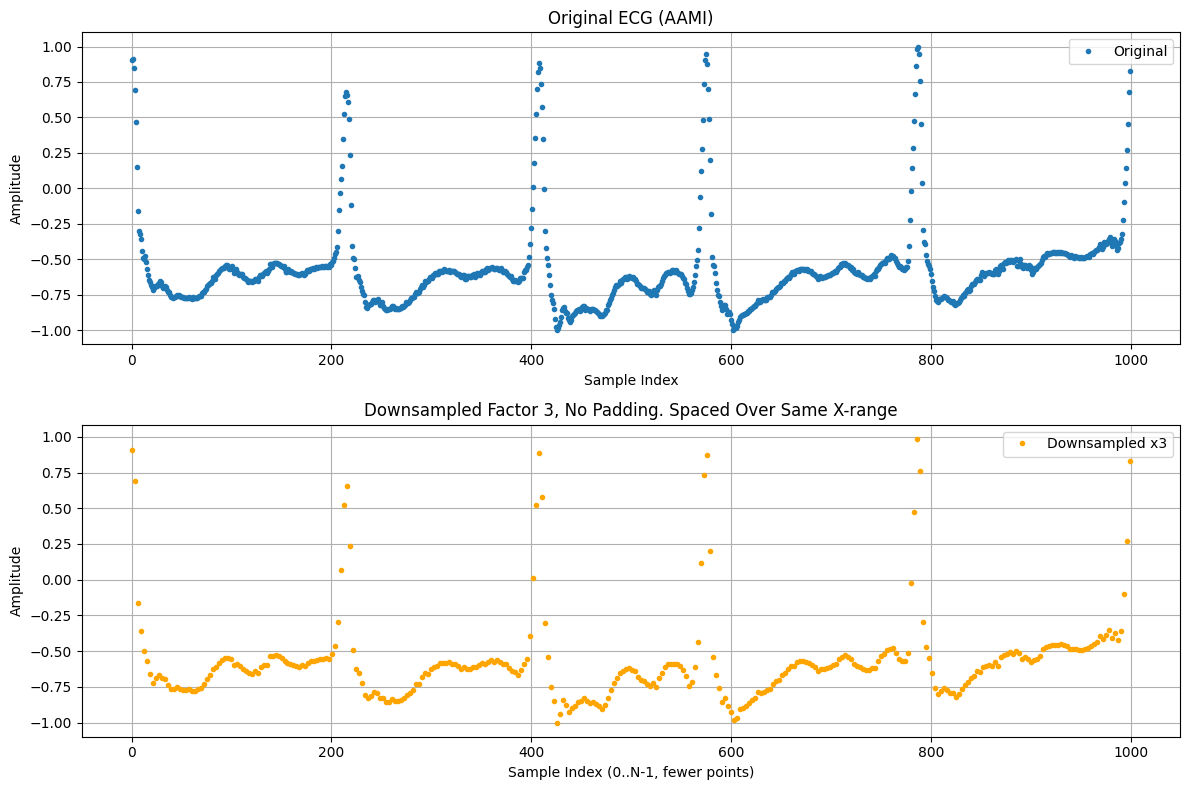

In [ ]:
import random
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def plot_random_multibeat_window_hrx3(dataset, label_filter=None, title_label='raw', figsize=(12, 8)):
    """
    Two subplots:
      1) Original resampled ECG window as discrete points ('o').
      2) A downsampled version (by factor 3, skipping 2/3 of samples),
         also plotted as discrete points, but stretched across the same x-range.
         => No sample padding or repetition. We just have fewer points
            spaced out over the same horizontal domain.

    So the second subplot "looks" like a 3× faster wave but with fewer points.
    """

    assert title_label in ['raw', 'aami'], "title_label must be 'raw' or 'aami'"

    # 1. Filter events if needed
    if label_filter:
        if isinstance(label_filter, str):
            label_filter = [label_filter]
        filtered_events = [e for e in dataset.labeled_events if e[2] in label_filter]
        if not filtered_events:
            print(f"❌ No samples found with label(s): {label_filter}")
            return
    else:
        filtered_events = dataset.labeled_events

    # 2. Pick a random event
    filename, ecg_tensor, raw_label, sample_num = random.choice(filtered_events)
    ecg_np = ecg_tensor.squeeze().numpy()  # shape ~ (N,)

    # 3. Setup figure
    fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=figsize)

    # -----------------
    # (A) Original wave
    # -----------------
    N = len(ecg_np)
    ax1.plot(np.arange(N), ecg_np, 'o', markersize=3, label="Original")
    ax1.set_title("Original ECG" if title_label=='raw' else "Original ECG (AAMI)")  # or adapt with your label logic
    ax1.set_xlabel("Sample Index")
    ax1.set_ylabel("Amplitude")
    ax1.grid(True)
    ax1.legend()

    # If you want to mark R-peaks from the dataset => do that:
    # ... (similar to your old code)
    # We'll skip that here for brevity – you can copy from your prior snippet.

    # -----------------
    # (B) Downsample by factor 3, space out
    # -----------------
    # Keep every 3rd sample => length ~ N/3
    ecg_ds = ecg_np[::3]
    M = len(ecg_ds)

    # Create an x-axis that spans the same 0..(N-1) range, but only has M points
    x_ds = np.linspace(0, N-1, M)
    # So the first point is x=0, last is x=N-1, in between are M-2 equally spaced points

    ax2.plot(x_ds, ecg_ds, 'o', markersize=3, color='orange', label="Downsampled x3")
    ax2.set_title("Downsampled Factor 3, No Padding. Spaced Over Same X-range")
    ax2.set_xlabel("Sample Index (0..N-1, fewer points)")
    ax2.set_ylabel("Amplitude")
    ax2.grid(True)
    ax2.legend()

    plt.tight_layout()
    plt.show()


plot_random_multibeat_window_hrx3(dataset, title_label='aami')
